In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import folium

from tqdm import tqdm_notebook
from glob import glob
from tqdm.auto import tqdm
import pickle

import CaGeo.algorithms.SegmentFeatures as sf

In [2]:
with open("Data/Not_Resampled/FIXED_not_resample_10km_LCSS/model.pkl", "rb") as fd: #in verità è 10km
    geolet = pickle.load(fd)

In [5]:
len(geolet.candidate_geolets)

6159

In [133]:
geolet.distance

In [14]:
geolets = geolet.candidate_geolets
geolets_keys = np.array(list(geolets.keys()))
dist_matrix = 1+geolet.selector.dist_matrix

In [15]:
np.min(dist_matrix)

0.16393228864196596

In [16]:
from sklearn.decomposition import PCA

dist_matrix_pca = PCA(n_components=2).fit_transform(dist_matrix)

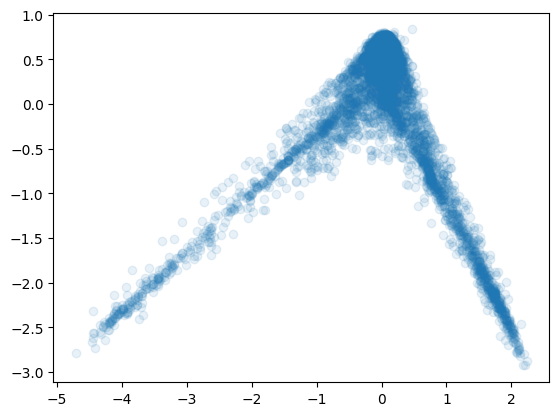

In [17]:
max_n_points = dist_matrix_pca.shape[0]

plt.scatter(dist_matrix_pca[:max_n_points, 0], dist_matrix_pca[:max_n_points, 1], alpha=.1)

  0%|          | 0/6159 [00:00<?, ?it/s]

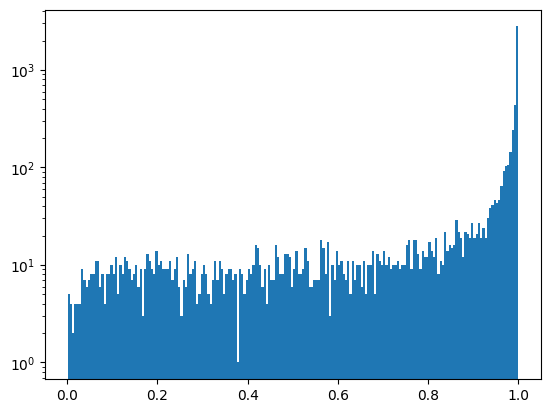

In [18]:
geolet_score = dict()

for geolet_id, geolet_data in tqdm(geolets.items()):
    val = sf.straightness(lat=geolet_data.latitude, lon=geolet_data.longitude)
    geolet_score[geolet_id] = val if np.isfinite(val) and not np.isnan(val) else .0

plt.hist(geolet_score.values(), bins=200)
plt.yscale("log")

## t-SNE

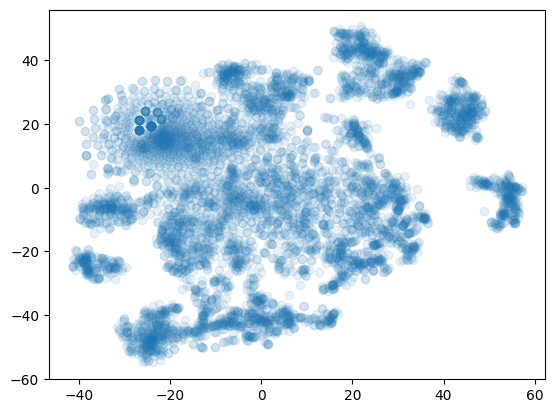

In [132]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, metric="precomputed", init="random", n_jobs=128, perplexity=35)

dist_matrix_tsne = tsne.fit_transform(dist_matrix)

plt.scatter(dist_matrix_tsne[:, 0], dist_matrix_tsne[:, 1], alpha=.1)

  0%|          | 0/11 [00:00<?, ?it/s]

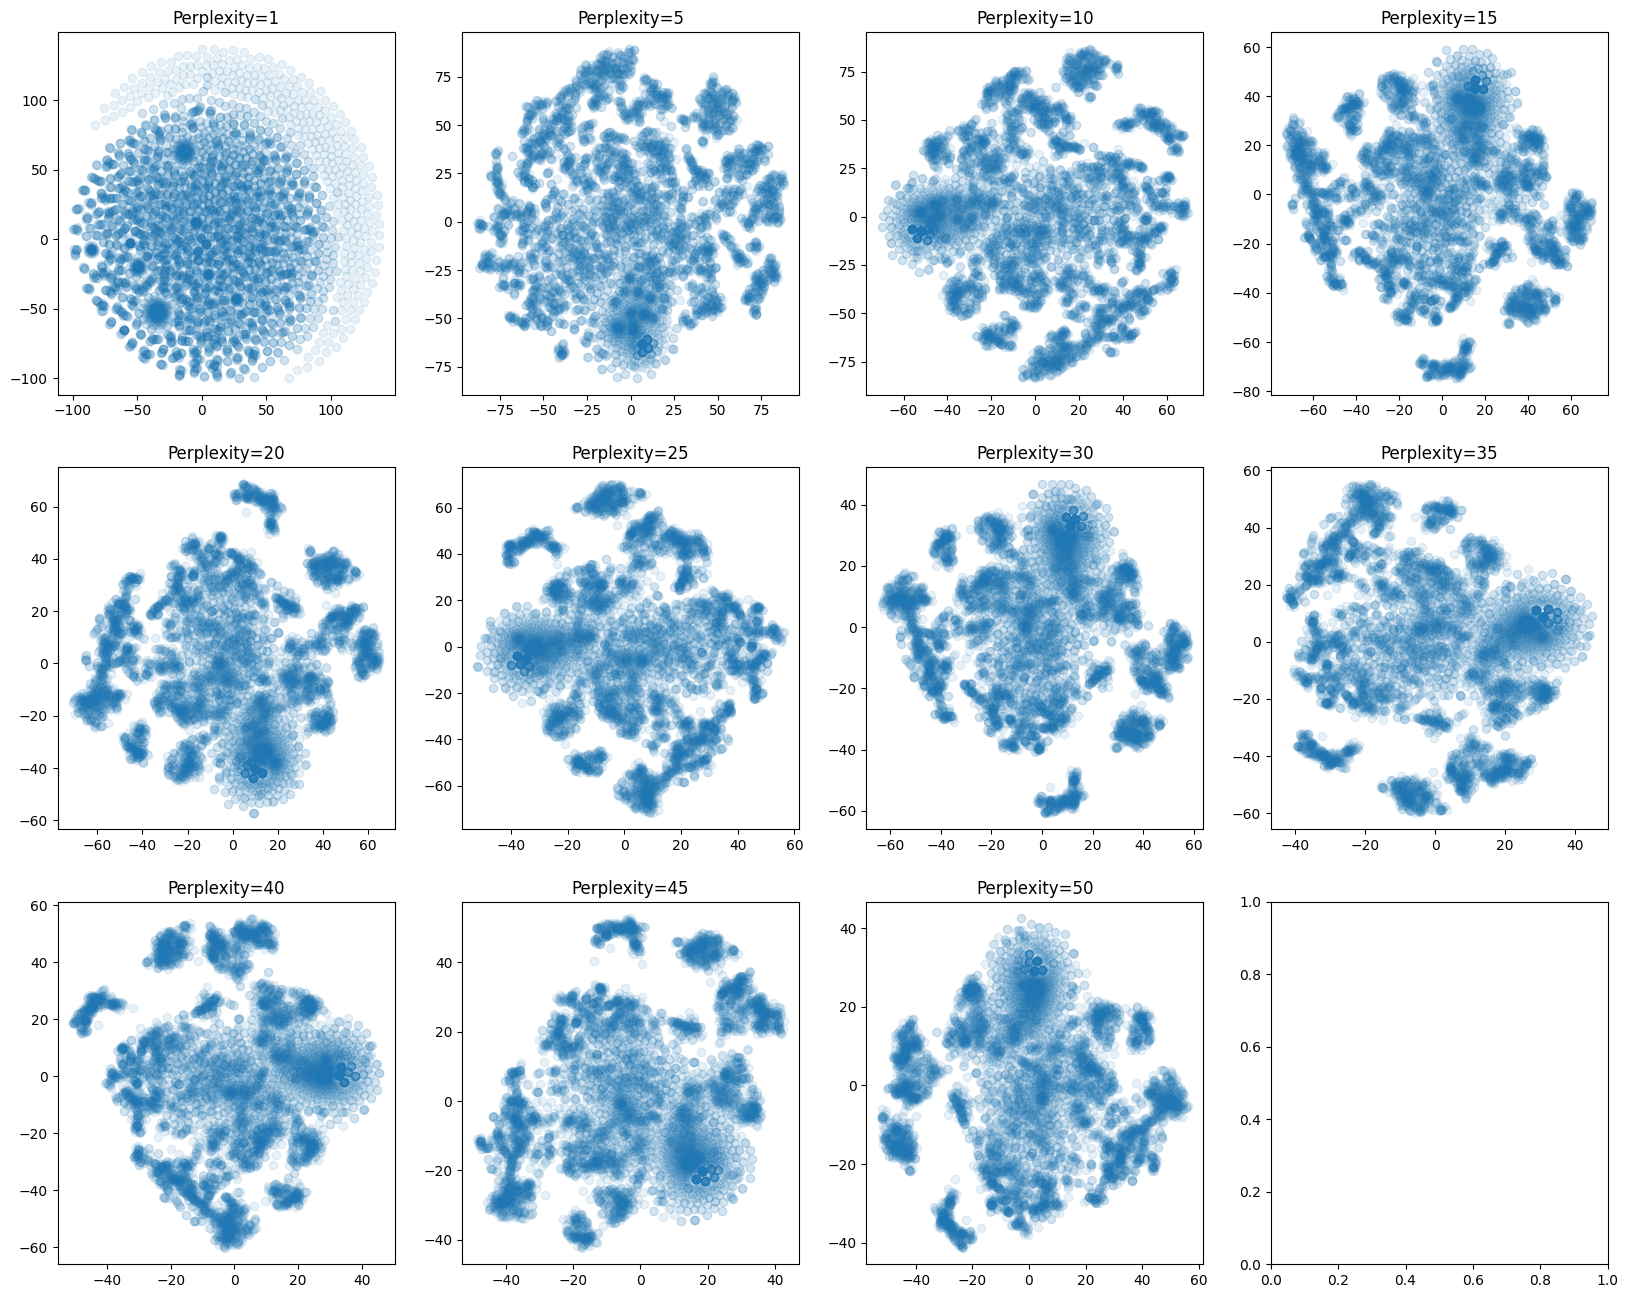

In [20]:
_, axs = plt.subplots(3, 4, figsize=(20, 16))
axs = axs.flatten()

for ax, perplexity in zip(axs, tqdm(range(0, 50+1, 5))):
    tsne = TSNE(n_components=2, metric="precomputed", init="random", n_jobs=128, perplexity=max(1, perplexity))

    dist_matrix_tsne_tmp = tsne.fit_transform(dist_matrix)
    
    ax.scatter(dist_matrix_tsne_tmp[:, 0], dist_matrix_tsne_tmp[:, 1], alpha=.1)
    ax.set_title(f'Perplexity={max(1, perplexity)}')

plt.show()

## UMAP

  0%|          | 0/8 [00:00<?, ?it/s]

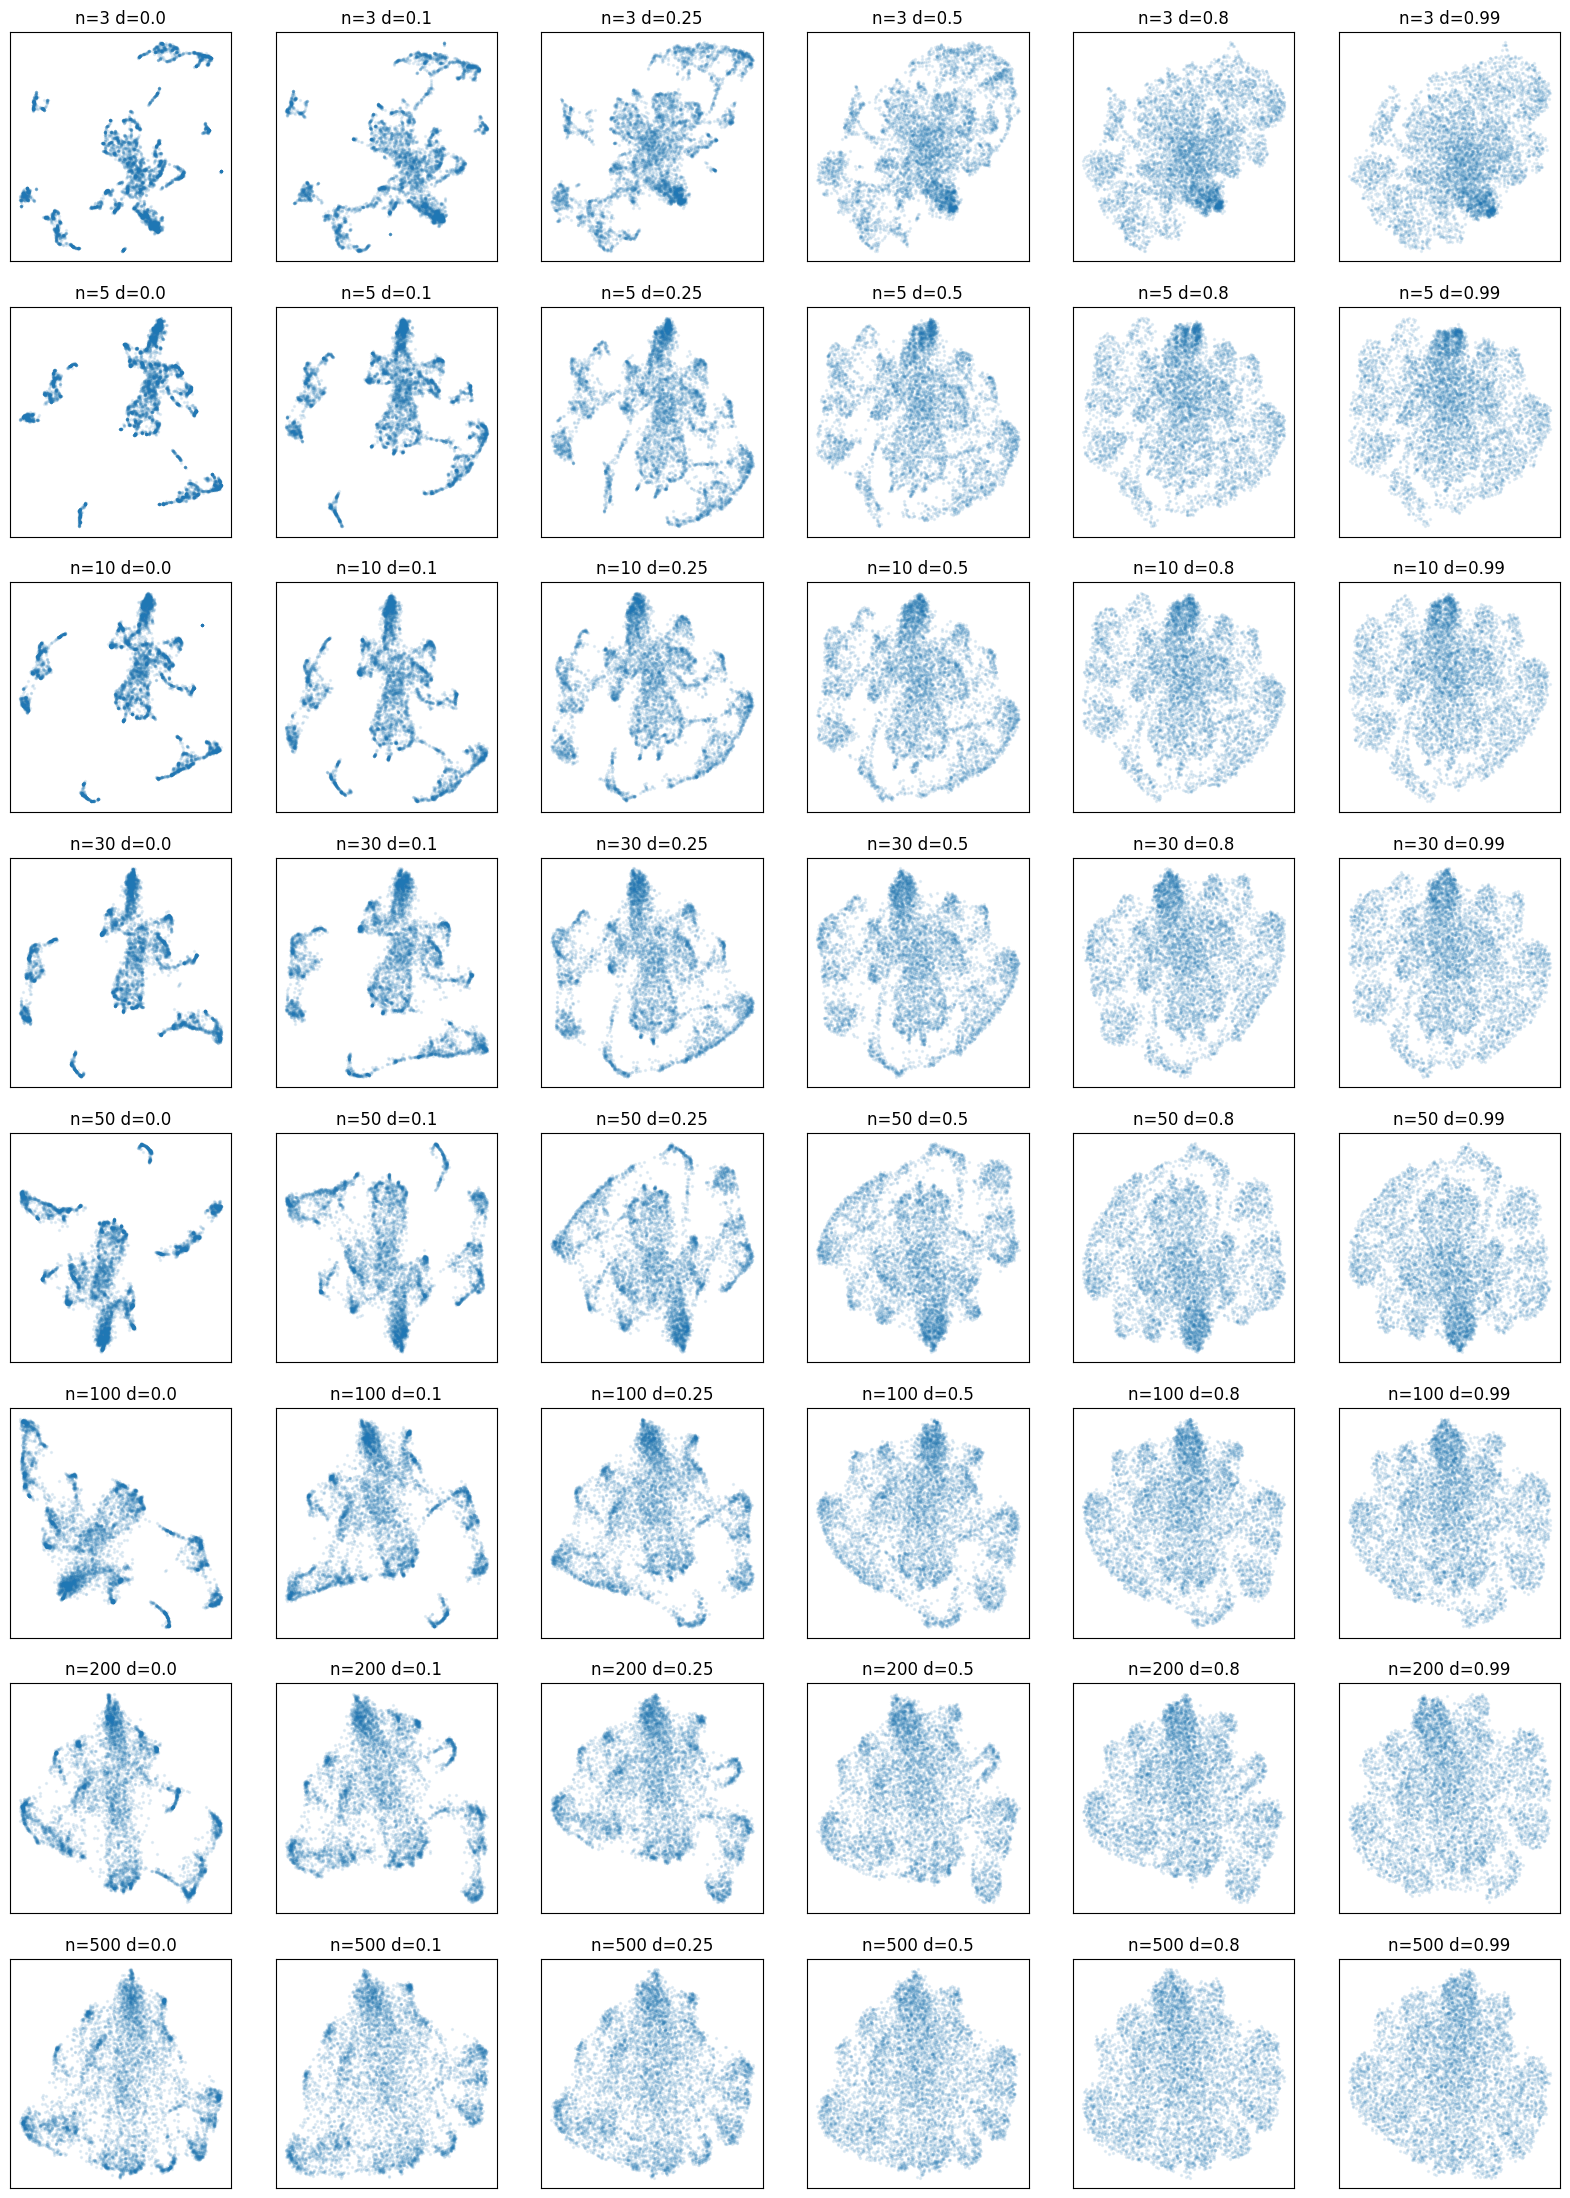

In [21]:
#pip install umap-learn
import umap
import warnings
warnings.filterwarnings("ignore")

n_neighbors_list = [3, 5, 10, 30, 50, 100, 200, 500]
min_dist_list = [0.0, 0.1, 0.25, 0.5, 0.8, 0.99]

_, axs = plt.subplots(len(n_neighbors_list), len(min_dist_list), figsize=(20, 28))

for i, n_neighbors in enumerate(tqdm(n_neighbors_list)):
    for j, min_dist in enumerate(min_dist_list):
        reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=2, metric='precomputed', min_dist=min_dist)
        embedding = reducer.fit_transform(dist_matrix)
        axs[i, j].scatter(embedding[:, 0], embedding[:, 1], alpha=.1, s=2)
        axs[i, j].set_title(f'n={n_neighbors} d={min_dist}')
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

plt.show()

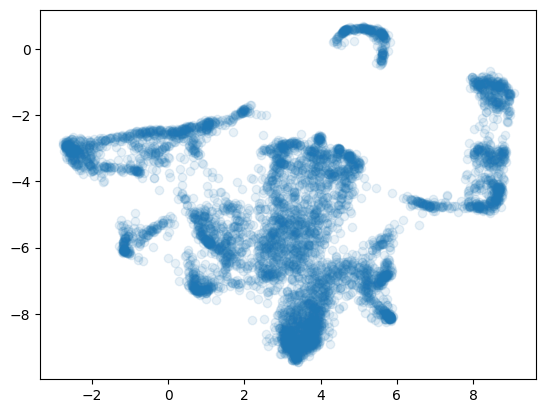

In [27]:
reducer = umap.UMAP(n_neighbors=50, n_components=2, metric='precomputed', min_dist=0.1)
embedding = reducer.fit_transform(dist_matrix)

plt.scatter(embedding[:, 0], embedding[:, 1], alpha=.1)

plt.show()

In [44]:
#dist_matrix_tsne = embedding

## RuleTree

In [32]:
from RuleTree import RuleTreeCluster
from RuleTree.stumps.regression import DecisionTreeStumpRegressor, ObliqueDecisionTreeStumpRegressor
from RuleTree.utils.bic_estimator import bic


rtc = RuleTreeCluster(n_components=100, bic_eps=1, max_depth=4)
rtc

RuleTreeCluster(base_stumps=DecisionTreeStumpRegressor(ccp_alpha=0.0,
                                                       criterion='squared_error',
                                                       max_depth=1,
                                                       max_features=None,
                                                       min_impurity_decrease=0.0,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       monotonic_cst=None,
                                                       random_state=None,
                                                       splitter='best'),
                bic_eps=1, max_depth=4, n_components=100)

In [33]:
rtc.fit(dist_matrix)

RuleTreeCluster(base_stumps=[(1.0,
                              DecisionTreeStumpRegressor(ccp_alpha=0.0,
                                                         criterion='squared_error',
                                                         max_depth=1,
                                                         max_features=None,
                                                         min_impurity_decrease=0.0,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         monotonic_cst=None,
                                                         random_state=None,
                                                         splitter='best'))],
                bic_eps=1, max_depth=4, n_components=100)

In [34]:
cluster_labels = rtc.predict(dist_matrix)

len(np.unique(cluster_labels))

2

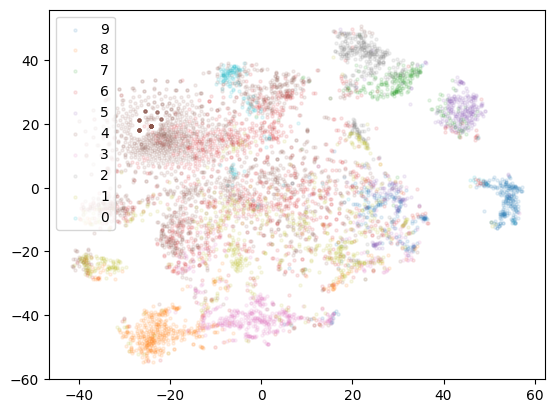

In [137]:
max_n_points = dist_matrix_pca.shape[0]

for label in sorted(np.unique(cluster_labels))[::-1]:
    dist_matrix_label = dist_matrix_tsne[label==cluster_labels]
    plt.scatter(dist_matrix_label[:min(dist_matrix_label.shape[0], max_n_points), 0], 
                dist_matrix_label[:min(dist_matrix_label.shape[0], max_n_points), 1], 
                alpha=.1 if label != -1 else .7, 
                s=5,
                label=label)

plt.legend()

## KMeans

In [153]:
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans

#km = KMedoids(n_clusters=7, metric='precomputed', max_iter=500)
km = KMeans(n_clusters=6, max_iter=300)
cluster_labels = km.fit_predict(dist_matrix_tsne)

In [154]:
medoids = dict()

intra_cluster_distance = np.zeros((len(geolets),))
for idx, label in enumerate(cluster_labels):
    intra_cluster_distance[idx] = np.sum(dist_matrix[idx][cluster_labels == label])

for label in tqdm(np.unique(cluster_labels), desc="Collecting medoids"):
    min_idx = np.argmin(intra_cluster_distance[cluster_labels == label])
    key = geolets_keys[cluster_labels == label][min_idx]
    medoids[f"cl={label}_{key}"] = geolets[key]
    scores = intra_cluster_distance[cluster_labels == label][min_idx]

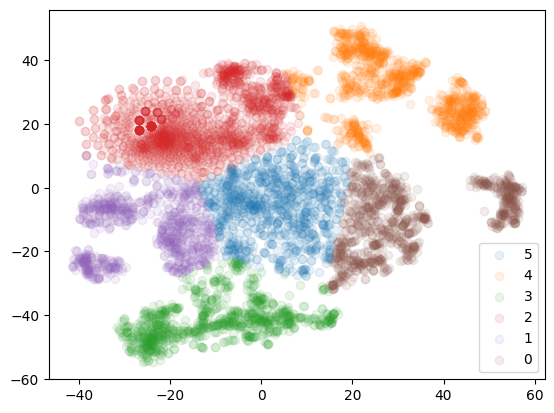

In [155]:
max_n_points = dist_matrix_pca.shape[0]

for label in sorted(np.unique(cluster_labels))[::-1]:
    dist_matrix_label = dist_matrix_tsne[label==cluster_labels]
    plt.scatter(dist_matrix_label[:min(dist_matrix_label.shape[0], max_n_points), 0], 
                dist_matrix_label[:min(dist_matrix_label.shape[0], max_n_points), 1], 
                alpha=.1 if label != -1 else .7, 
                label=label)

plt.legend()

  0%|          | 0/6 [00:00<?, ?it/s]

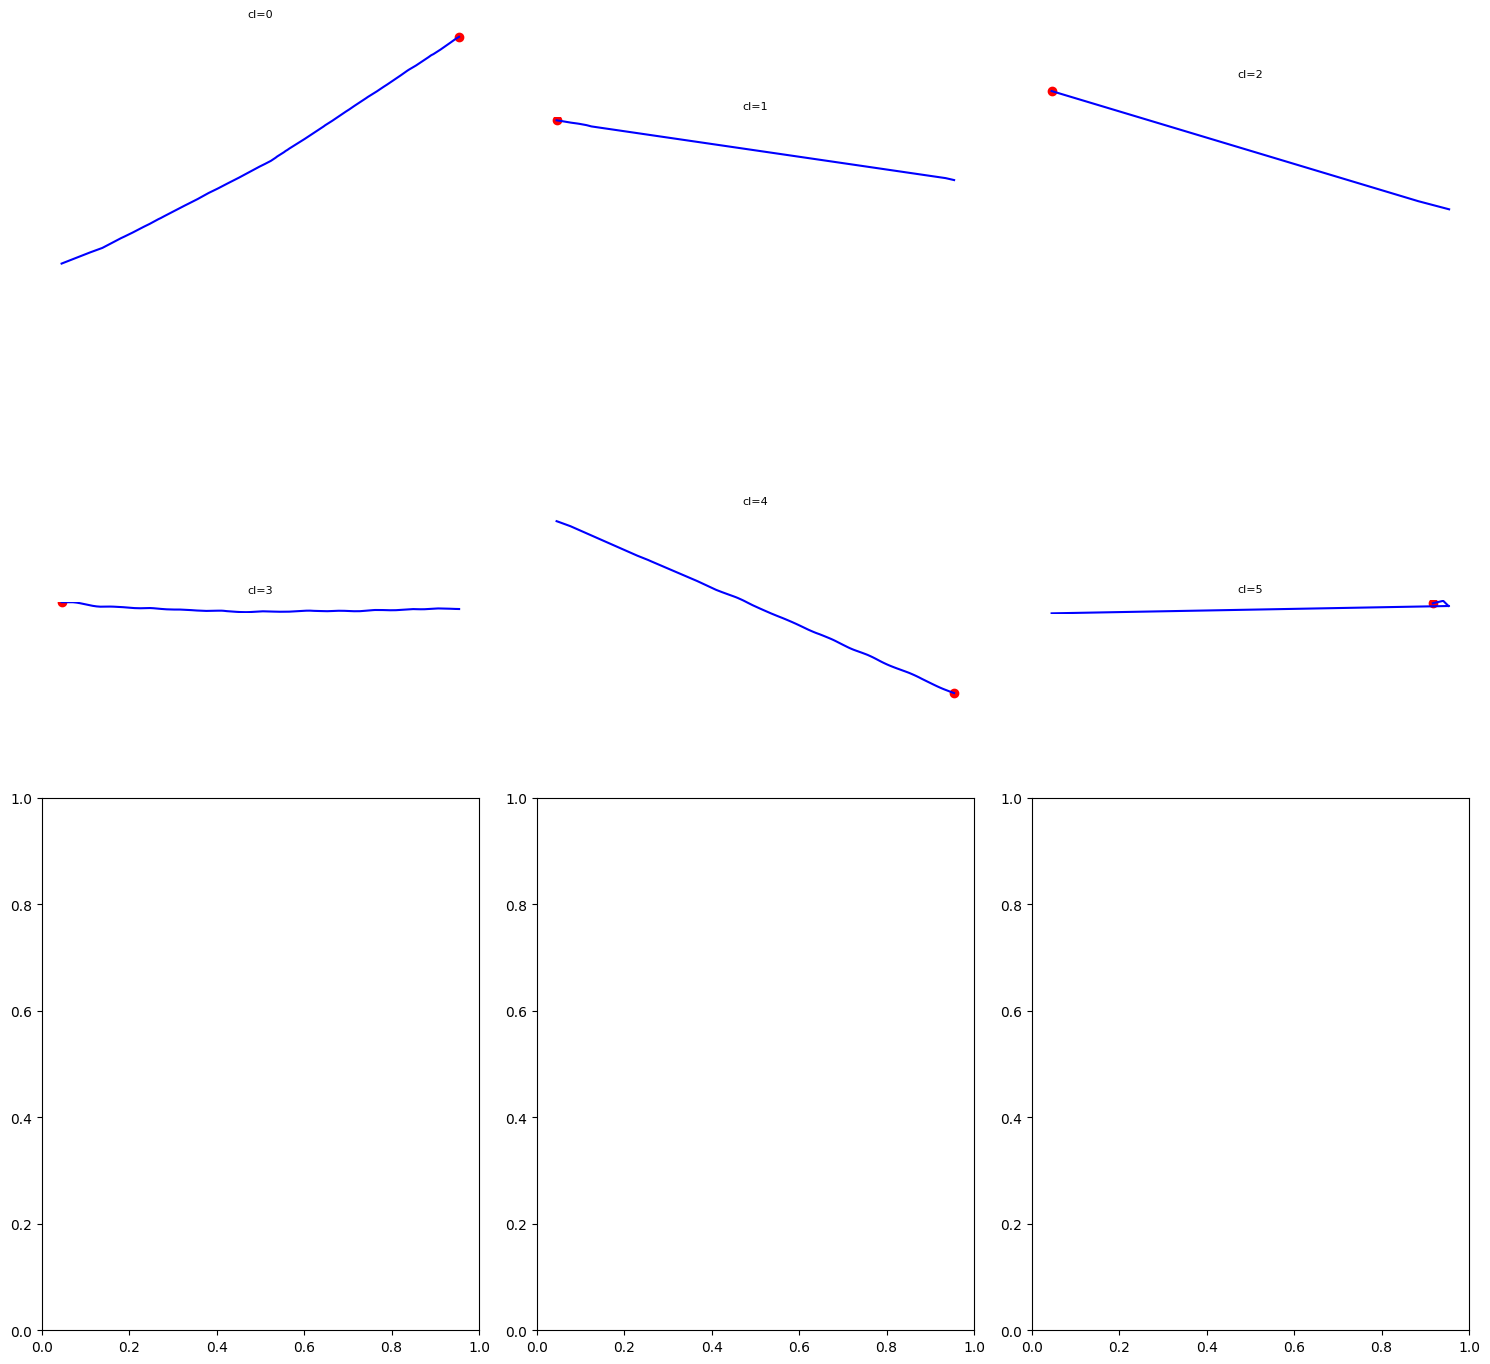

In [156]:
import math

fig, axes = plt.subplots(math.ceil(len(medoids)**.5), math.ceil(len(medoids)**.5), figsize=(15, 15))
axes = axes.flatten()

for ax, (geolet_id, geolet_data) in zip(axes, tqdm(medoids.items())):
    ax.plot(geolet_data.longitude, geolet_data.latitude, color='blue')
    ax.scatter(geolet_data.longitude[0], geolet_data.latitude[0], color='red')
    ax.set_title(geolet_id.split("_")[0], fontsize=8)
    ax.set_aspect('equal')  # stessa scala per x e y
    ax.axis('off')  # opzionale, per rimuovere gli assi

plt.tight_layout()
plt.show()

## Local Outlier Factor

In [157]:
from sklearn.neighbors import LocalOutlierFactor

#km = KMedoids(n_clusters=20, metric='precomputed', max_iter=100)
lof = LocalOutlierFactor(n_neighbors=20, metric='precomputed')
lof_result = lof.fit_predict(dist_matrix)

In [158]:
len(lof_result[lof_result==-1])

10

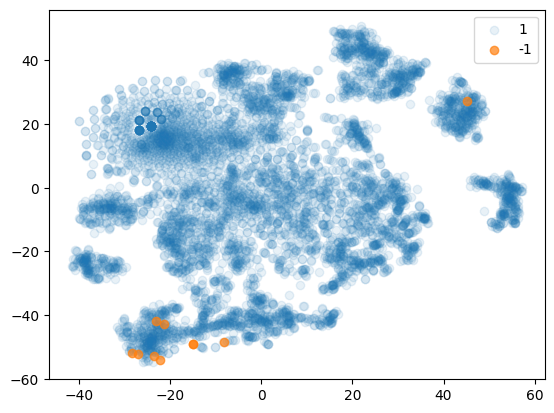

In [159]:
max_n_points = 10000

for label in sorted(np.unique(lof_result))[::-1]:
    dist_matrix_label = dist_matrix_tsne[label==lof_result]
    plt.scatter(dist_matrix_label[:min(dist_matrix_label.shape[0], max_n_points), 0], 
                dist_matrix_label[:min(dist_matrix_label.shape[0], max_n_points), 1], 
                alpha=.1 if label != -1 else .7, 
                label=label)

plt.legend()

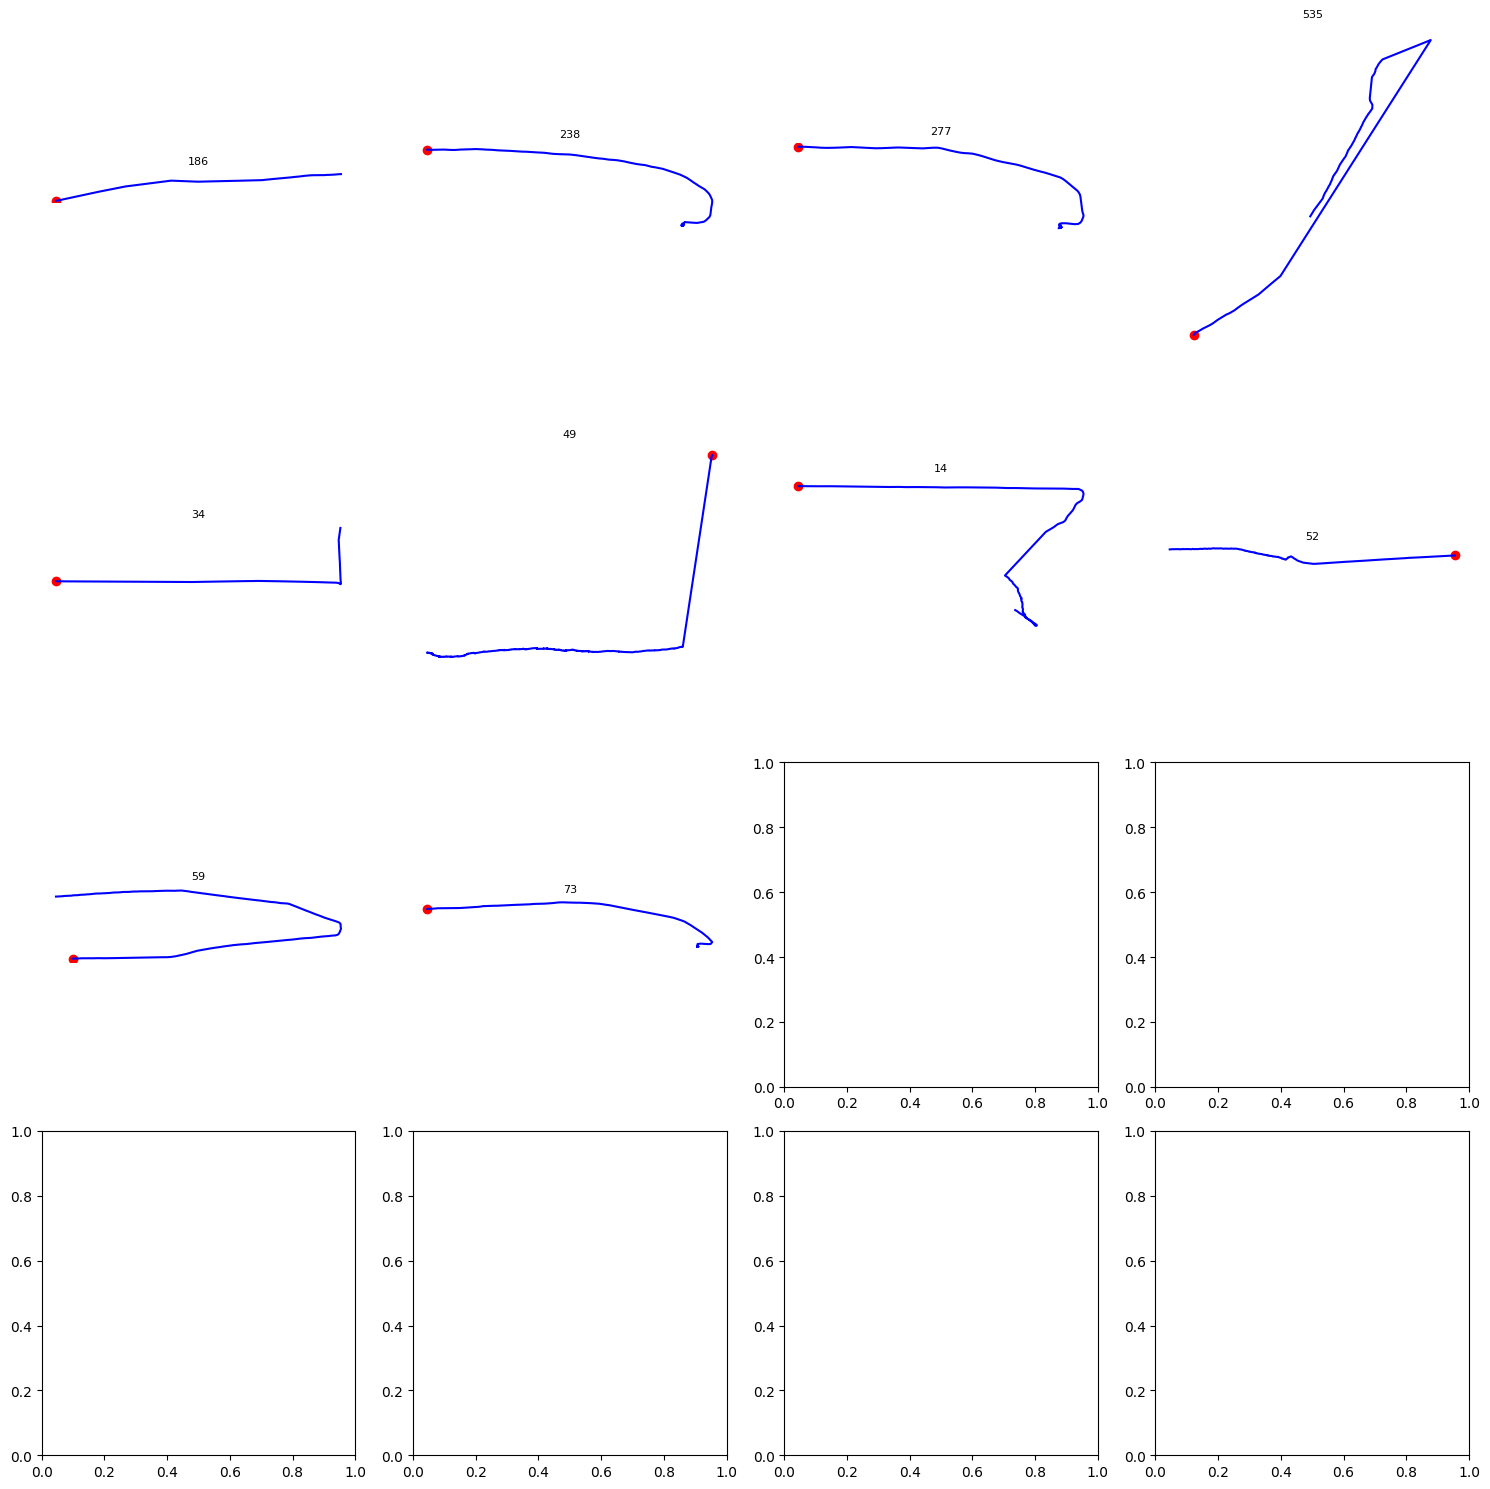

In [58]:
geolets_keys[lof_result[lof_result==-1]]

import math

fig, axes = plt.subplots(math.ceil(len(medoids)**.5), math.ceil(len(medoids)**.5), figsize=(15, 15))
axes = axes.flatten()

for ax, geolet_id in zip(axes, geolets_keys[lof_result==-1]):
    geolet_data = geolets[geolet_id]
    ax.plot(geolet_data.longitude, geolet_data.latitude, color='blue')
    ax.scatter(geolet_data.longitude[0], geolet_data.latitude[0], color='red')
    ax.set_title(geolet_id.split("_")[0], fontsize=8)
    ax.set_aspect('equal')  # stessa scala per x e y
    ax.axis('off')  # opzionale, per rimuovere gli assi

plt.tight_layout()
plt.show()

## Elliptic Envelope

runtime exceeds limits

from sklearn.covariance import EllipticEnvelope

ee = EllipticEnvelope()
ee_result = ee.fit_predict(dist_matrix)

ee_result

## Isolation Forest

In [59]:
from sklearn.ensemble import IsolationForest

isof = IsolationForest(n_estimators=1000, contamination=.002)
isof_result = isof.fit_predict(dist_matrix)

In [60]:
len(isof_result[isof_result==-1])

13

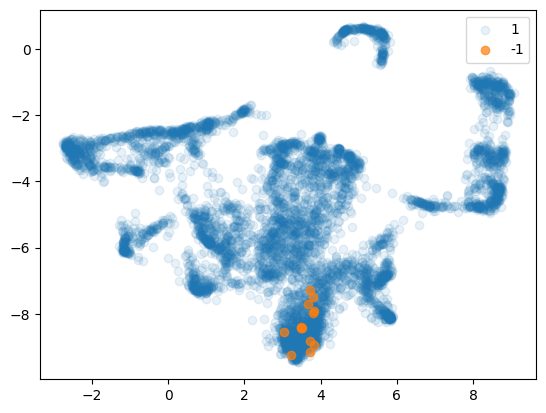

In [61]:
max_n_points =  10000

for label in sorted(np.unique(isof_result))[::-1]:
    dist_matrix_label = dist_matrix_tsne[label==isof_result]
    plt.scatter(dist_matrix_label[:min(dist_matrix_label.shape[0], max_n_points), 0], 
                dist_matrix_label[:min(dist_matrix_label.shape[0], max_n_points), 1], 
                alpha=.1 if label != -1 else .7, 
                label=label)

plt.legend()

98_226177000
99_226177000
24_226179000
441_227114300
442_227300000
149_227327000
5_227867000
75_227867000
111_228020600
57_228131000
5_228236000
8_228374000
5_228954000


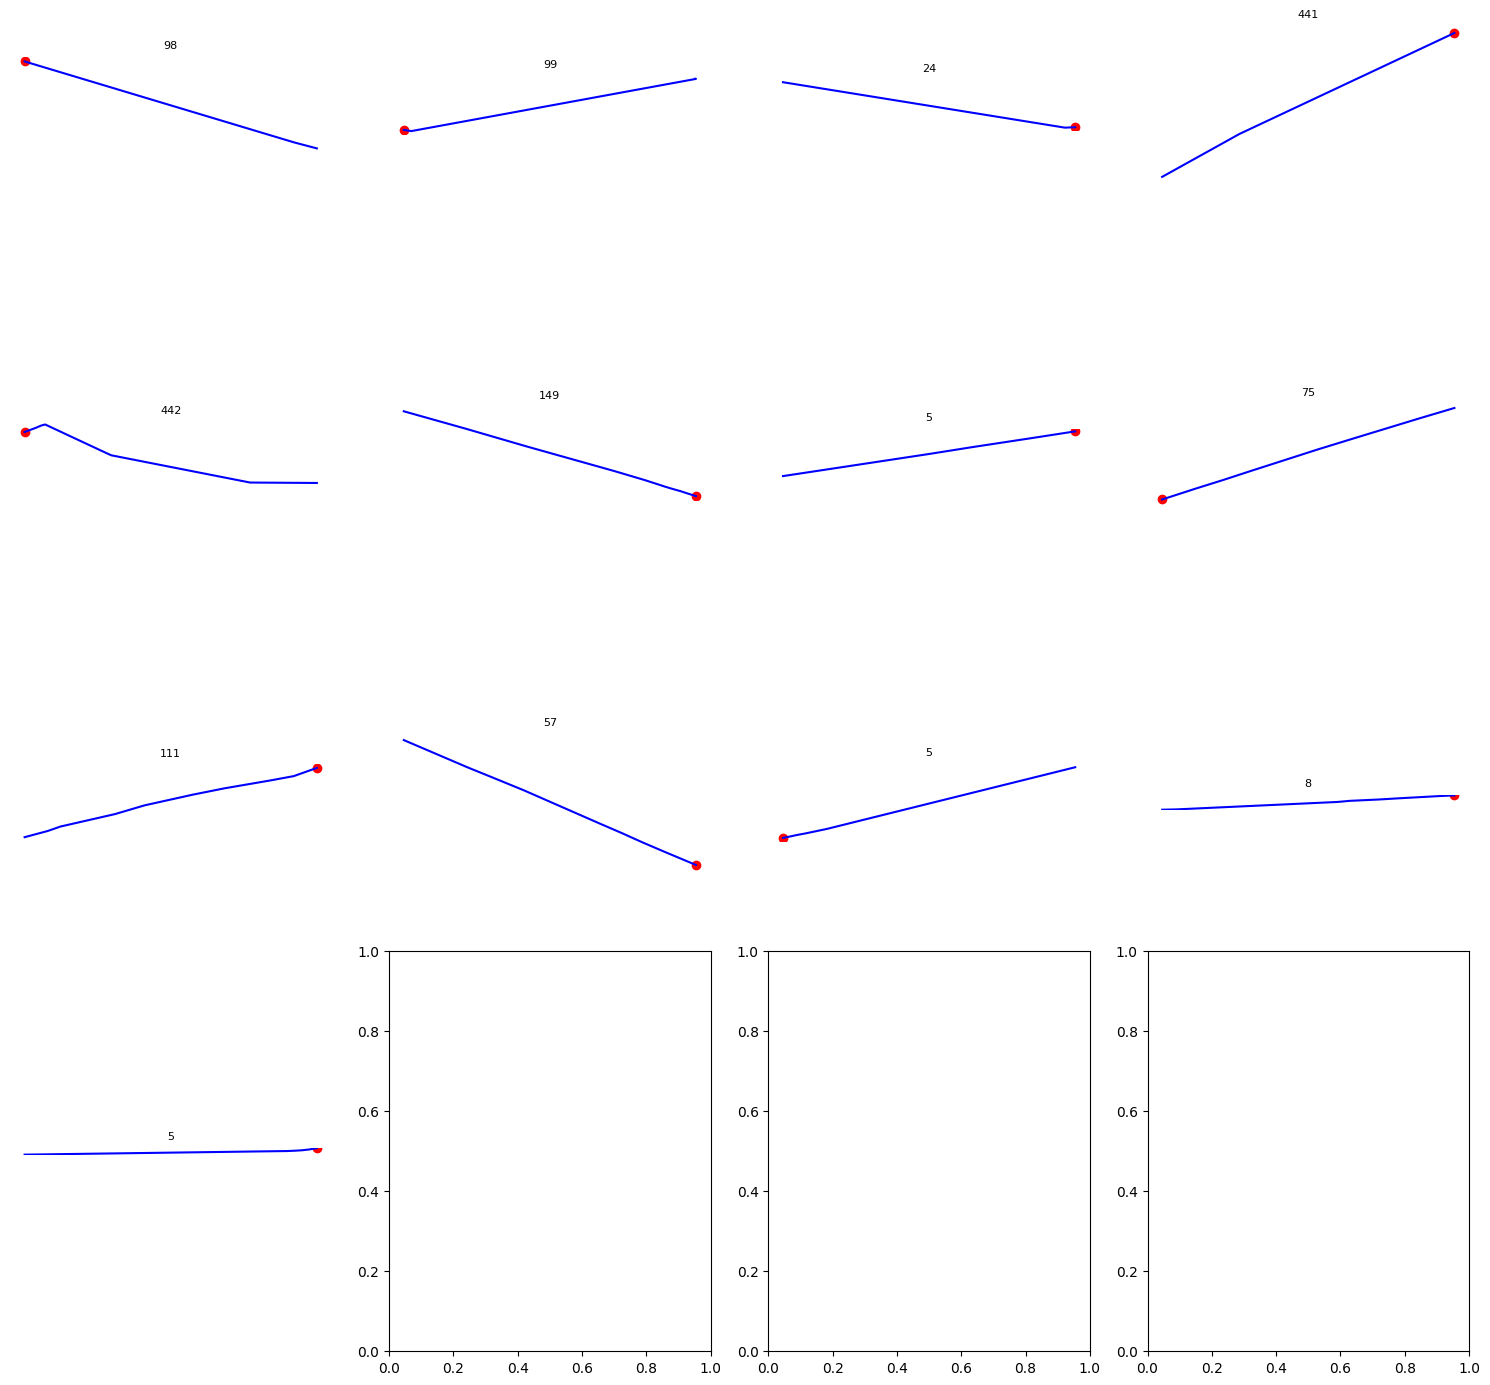

In [62]:
import math

fig, axes = plt.subplots(math.ceil(len(medoids)**.5), math.ceil(len(medoids)**.5), figsize=(15, 15))
axes = axes.flatten()

for ax, geolet_id in zip(axes, geolets_keys[isof_result==-1]):
    print(geolet_id)
    geolet_data = geolets[geolet_id]
    ax.plot(geolet_data.longitude, geolet_data.latitude, color='blue')
    ax.scatter(geolet_data.longitude[0], geolet_data.latitude[0], color='red')
    ax.set_title(geolet_id.split("_")[0], fontsize=8)
    ax.set_aspect('equal')  # stessa scala per x e y
    ax.axis('off')  # opzionale, per rimuovere gli assi

plt.tight_layout()
plt.show()

## OPTICS

In [120]:
from sklearn.cluster import OPTICS

#op = OPTICS(n_jobs=64)
op = OPTICS(n_jobs=64, metric='precomputed')
op_result = op.fit_predict(dist_matrix)

In [121]:
len(np.unique(op_result))

24

In [240]:
medoids = dict()

intra_cluster_distance = np.zeros((len(geolets),))
for idx, label in enumerate(op_result):
    intra_cluster_distance[idx] = np.sum(dist_matrix[idx][op_result == label])

for label in tqdm(np.unique(op_result), desc="Collecting medoids"):
    min_idx = np.argmin(intra_cluster_distance[op_result == label])
    key = geolets_keys[op_result == label][min_idx]
    medoids[f"cl={label}_{key}"] = geolets[key]
    scores = intra_cluster_distance[op_result == label][min_idx]

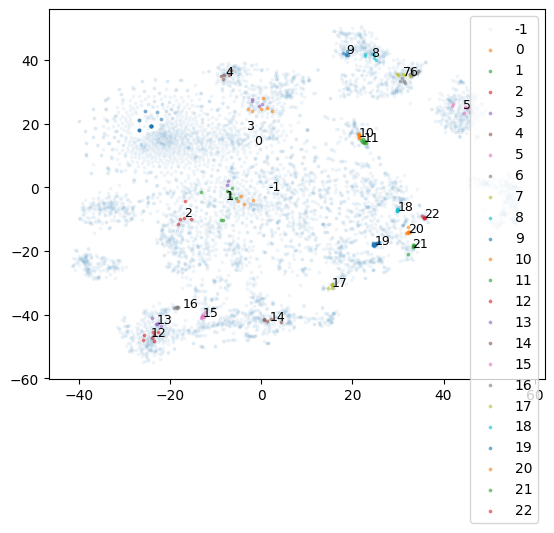

In [248]:
max_n_points = dist_matrix_pca.shape[0]

for label in sorted(np.unique(op_result))[::]:
    dist_matrix_pca_label = dist_matrix_tsne[label==op_result]
    plt.scatter(dist_matrix_pca_label[:min(dist_matrix_pca_label.shape[0], max_n_points), 0], 
                dist_matrix_pca_label[:min(dist_matrix_pca_label.shape[0], max_n_points), 1], 
                alpha=.05 if label == -1 else .5, 
                s=3,
                label=label)
    plt.text(np.mean(dist_matrix_pca_label[:min(dist_matrix_pca_label.shape[0], max_n_points), 0]), 
             np.mean(dist_matrix_pca_label[:min(dist_matrix_pca_label.shape[0], max_n_points), 1]), 
             str(label), fontsize=9)
plt.legend()

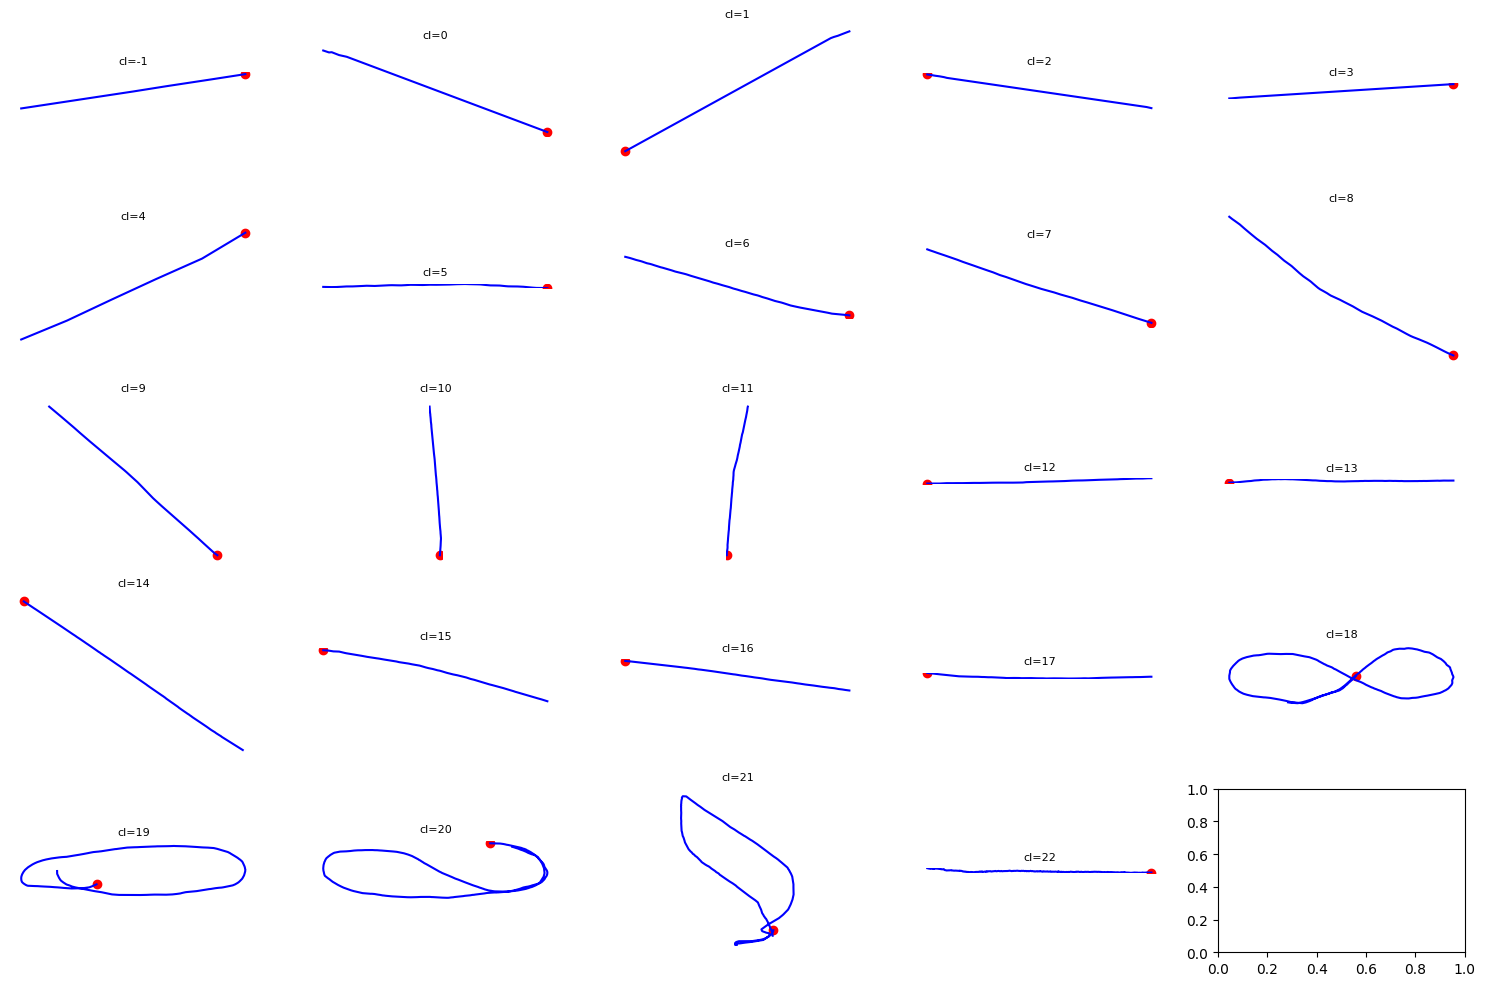

In [243]:
import math

fig, axes = plt.subplots(math.ceil(len(medoids)**.5), math.ceil(len(medoids)**.5), figsize=(15, 10))
axes = axes.flatten()

for ax, (geolet_id, geolet_data) in zip(axes, medoids.items()):
    ax.plot(geolet_data.longitude, geolet_data.latitude, color='blue')
    ax.scatter(geolet_data.longitude[0], geolet_data.latitude[0], color='red')
    ax.set_title(geolet_id.split("_")[0], fontsize=8)
    ax.set_aspect('equal')  # stessa scala per x e y
    ax.axis('off')  # opzionale, per rimuovere gli assi

plt.tight_layout()
plt.show()

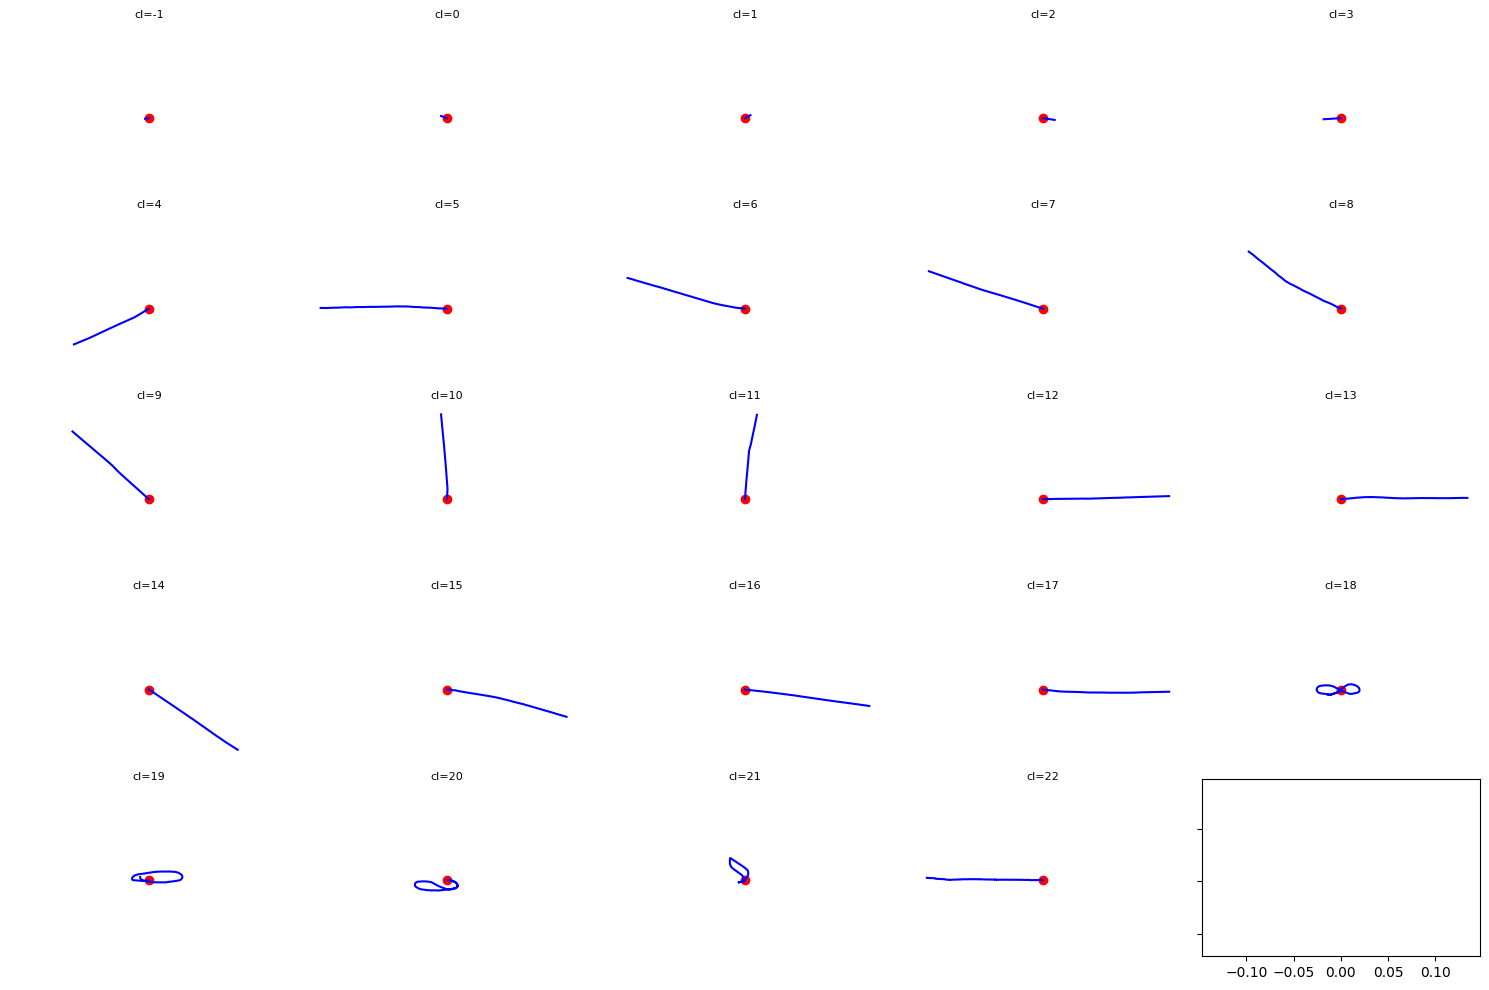

In [249]:
import math

fig, axes = plt.subplots(math.ceil(len(medoids)**.5), math.ceil(len(medoids)**.5), figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

for ax, (geolet_id, geolet_data) in zip(axes, medoids.items()):
    ax.plot(geolet_data.longitude-geolet_data.longitude[0], 
            geolet_data.latitude-geolet_data.latitude[0], color='blue')
    ax.scatter([0], [0], color='red')
    ax.set_title(geolet_id.split("_")[0], fontsize=8)
    ax.set_aspect('equal')  # stessa scala per x e y
    ax.axis('off')  # opzionale, per rimuovere gli assi

plt.tight_layout()
plt.show()

In [256]:
[print(f'Cluster {label}: {counts}') for label, counts in zip(*np.unique(op_result, return_counts=True))]
None

Cluster -1: 5995
Cluster 0: 10
Cluster 1: 10
Cluster 2: 5
Cluster 3: 6
Cluster 4: 5
Cluster 5: 7
Cluster 6: 13
Cluster 7: 5
Cluster 8: 6
Cluster 9: 5
Cluster 10: 7
Cluster 11: 9
Cluster 12: 7
Cluster 13: 5
Cluster 14: 5
Cluster 15: 7
Cluster 16: 6
Cluster 17: 5
Cluster 18: 6
Cluster 19: 14
Cluster 20: 9
Cluster 21: 7
Cluster 22: 5


  0%|          | 0/9 [00:00<?, ?it/s]

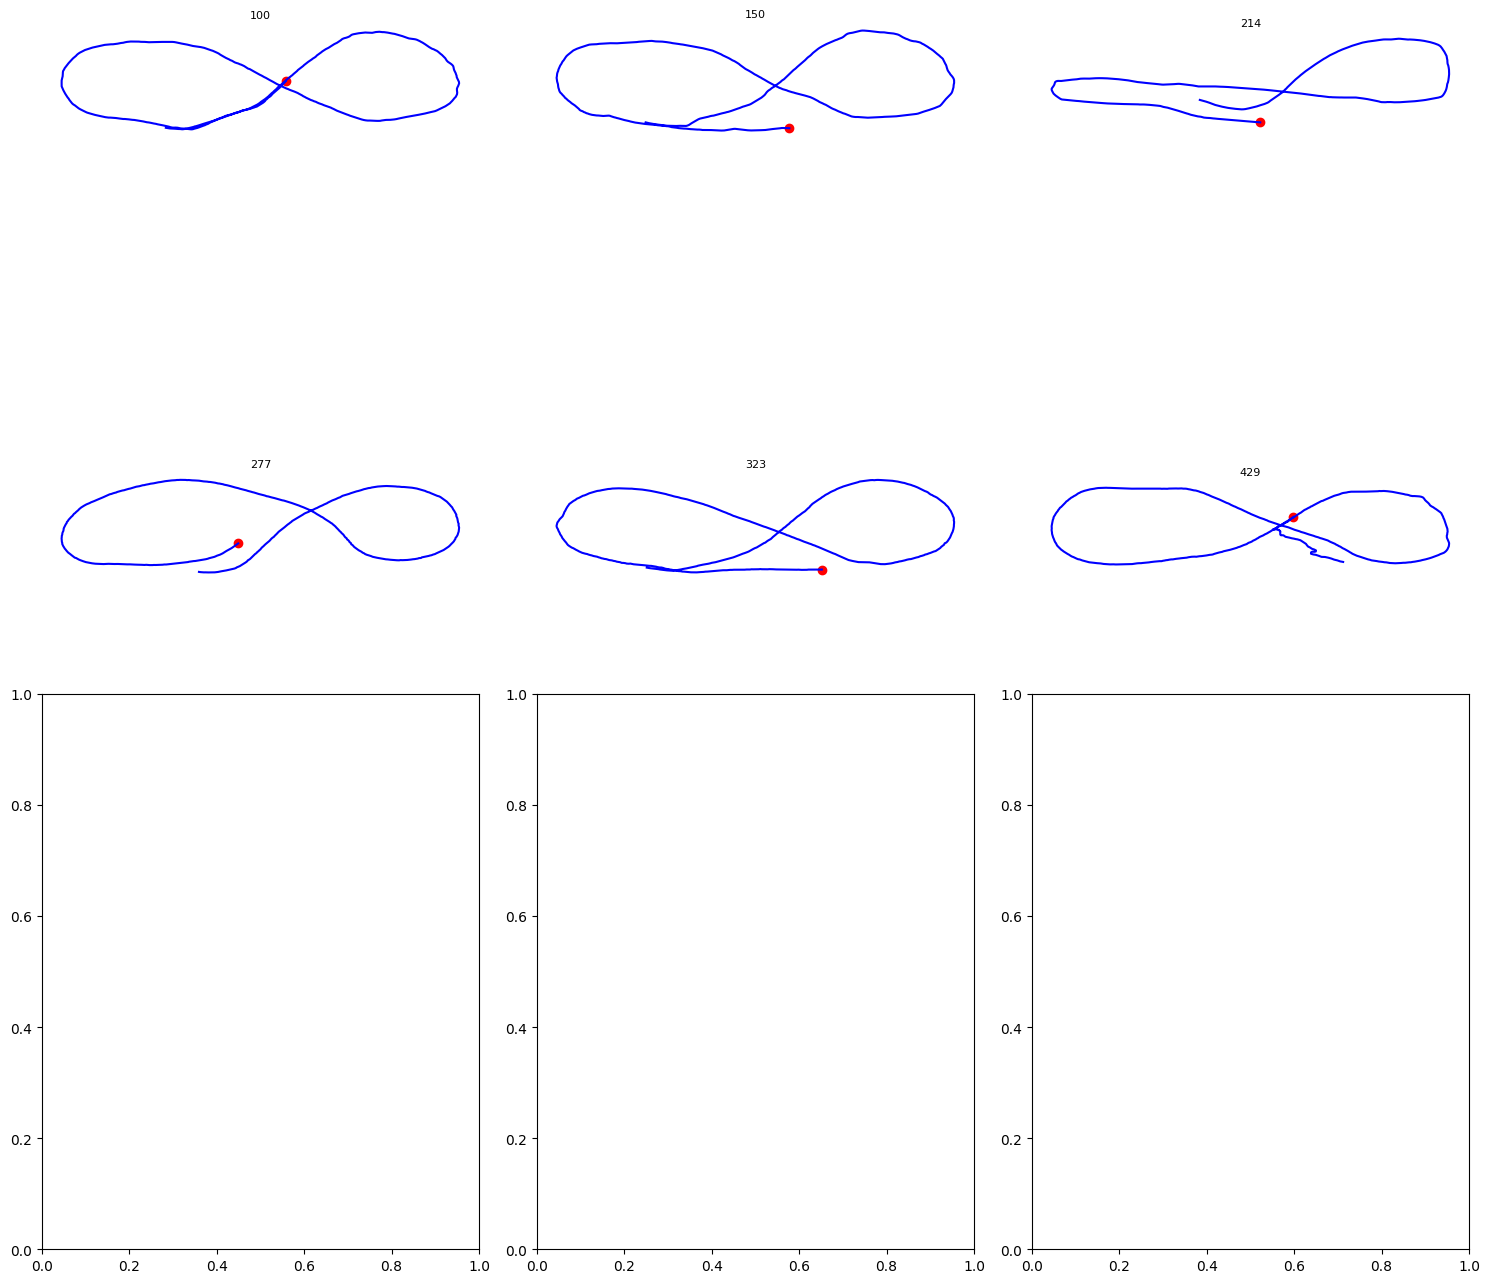

In [250]:
def plot_some_cluster_elements(labels, clu_id):
    selected_point = np.where(labels == clu_id)[0][:100]

    
    medoids = dict()
    for idx in selected_point:
        medoids[f'{geolets_keys[::sub_int][idx]}'] = geolets[geolets_keys[::sub_int][idx]]

    fig, axes = plt.subplots(math.ceil(len(medoids)**.5), math.ceil(len(medoids)**.5), figsize=(15, 15))
    axes = axes.flatten()
    
    for ax, (geolet_id, geolet_data) in zip(tqdm(axes), medoids.items()):
        ax.plot(geolet_data.longitude, geolet_data.latitude, color='blue')
        ax.scatter(geolet_data.longitude[0], geolet_data.latitude[0], color='red')
        ax.set_title(geolet_id.split("_")[0], fontsize=8)
        ax.set_aspect('equal')  # stessa scala per x e y
        ax.axis('off')  # opzionale, per rimuovere gli assi
    
    plt.tight_layout()
    plt.show()

plot_some_cluster_elements(op_result, 18)

## Biclustering

In [160]:
def visualize_biclustering(model, data, scale=False):
    data_scaled = data/np.max(data) if scale else data

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes = axes.flatten()
    
    fit_data = data_scaled[np.argsort(model.row_labels_)]
    fit_data = fit_data[:, np.argsort(model.column_labels_)]
    
    axes[0].matshow(fit_data, cmap=plt.cm.Blues)
    axes[0].set_title("Biclustering rearranged")

    axes[1].matshow(np.outer(np.sort(model.row_labels_) + 1, np.sort(model.column_labels_) + 1), cmap=plt.cm.Blues,)
    axes[1].set_title("Checkerboard structure of rearranged data")

In [161]:
from sklearn.cluster import SpectralBiclustering, SpectralCoclustering

n_cluster = 10

scc = SpectralCoclustering(n_clusters=n_cluster)
sbc = SpectralBiclustering(n_clusters=n_cluster)

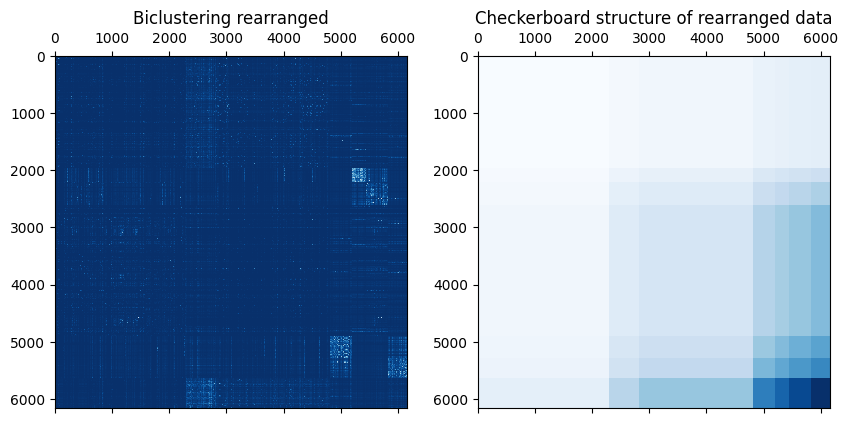

In [162]:
scc.fit(dist_matrix)
visualize_biclustering(scc, dist_matrix, scale=False)

In [163]:
from sklearn.metrics import pairwise_distances_argmin_min

medoids = []
for i in tqdm(range(scc.n_clusters)):
    cluster_rows = dist_matrix[scc.rows_[i]]
    centroid = cluster_rows.mean(axis=0)
    idx, _ = pairwise_distances_argmin_min([centroid], cluster_rows)
    medoids.append(idx[0])




fig, axes = plt.subplots(math.ceil(len(medoids)**.5), math.ceil(len(medoids)**.5), figsize=(15, 15))
axes = axes.flatten()

for i, geolet_key in enumerate(geolets_keys[medoids]):
    ax = axes[i]
    geolet_data = geolets[geolet_key]
    
    ax.plot(geolet_data.longitude, geolet_data.latitude)
    ax.set_title(geolet_key.split("_")[0], fontsize=8)
    ax.set_aspect('equal')  # stessa scala per x e y
    ax.axis('off')  # opzionale, per rimuovere gli assi
    
plt.tight_layout()
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

ValueError: Input contains NaN.

In [164]:
sbc.fit(dist_matrix)

SpectralBiclustering(n_clusters=10)

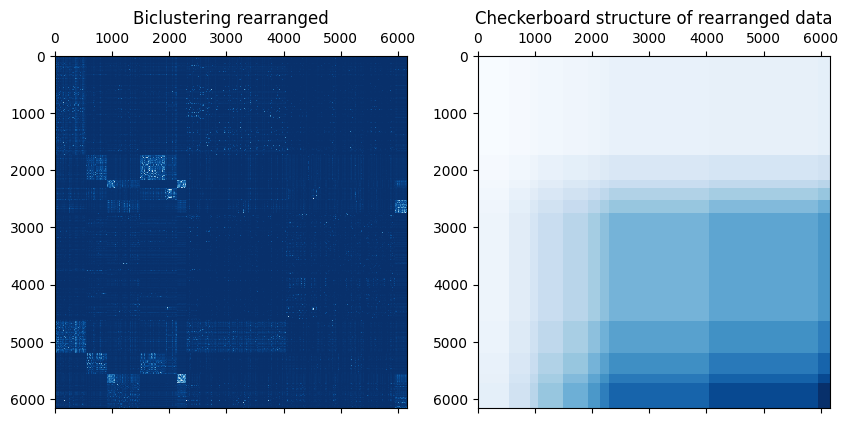

In [166]:
visualize_biclustering(sbc, dist_matrix, scale=False)

  0%|          | 0/10 [00:00<?, ?it/s]

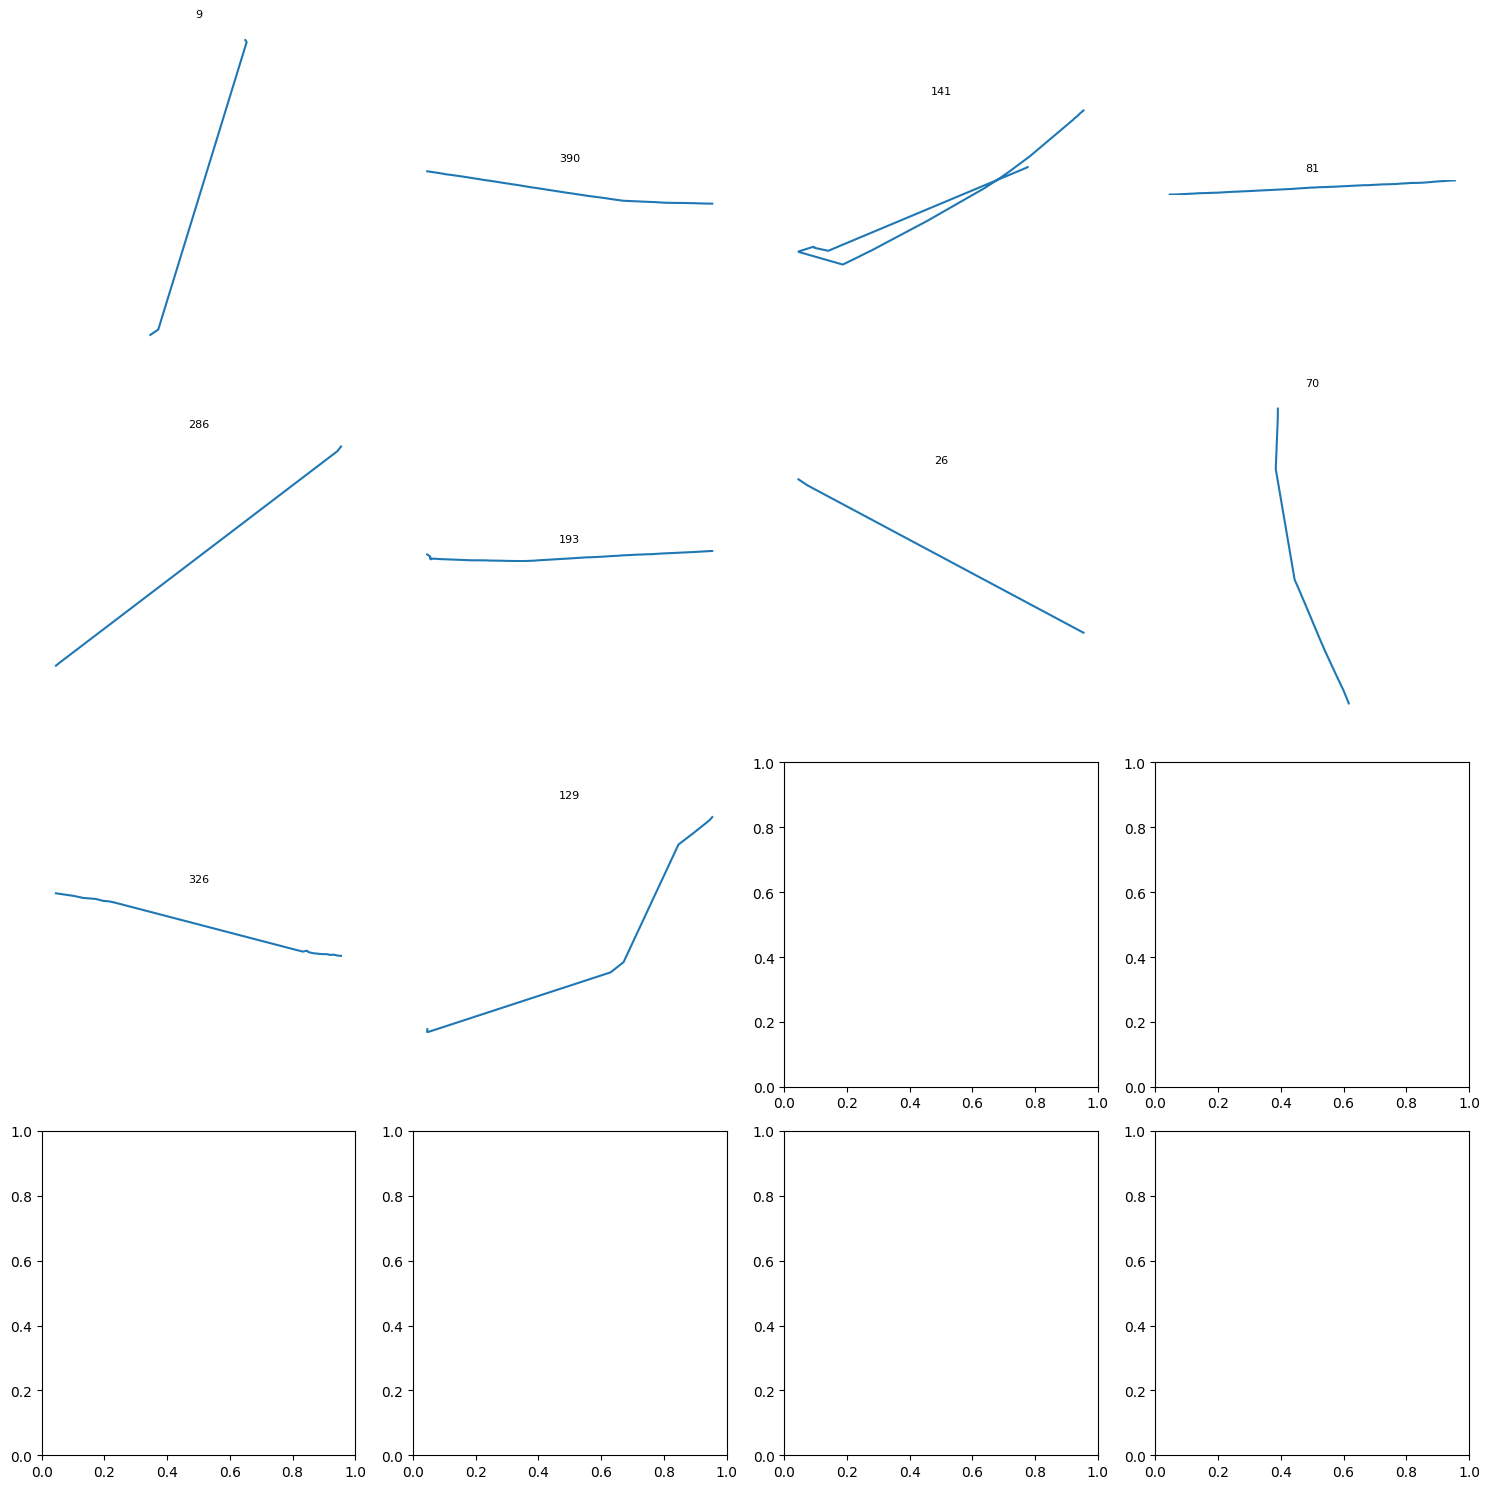

In [165]:
from sklearn.metrics import pairwise_distances_argmin_min

medoids = []
for i in tqdm(range(sbc.n_clusters)):
    cluster_rows = dist_matrix[sbc.columns_[i]]
    centroid = cluster_rows.mean(axis=0)
    idx, _ = pairwise_distances_argmin_min([centroid], cluster_rows)
    medoids.append(idx[0])




fig, axes = plt.subplots(math.ceil(len(medoids)**.5), math.ceil(len(medoids)**.5), figsize=(15, 15))
axes = axes.flatten()

for i, geolet_key in enumerate(geolets_keys[medoids]):
    ax = axes[i]
    geolet_data = geolets[geolet_key]
    
    ax.plot(geolet_data.longitude, geolet_data.latitude)
    ax.set_title(geolet_key.split("_")[0], fontsize=8)
    ax.set_aspect('equal')  # stessa scala per x e y
    ax.axis('off')  # opzionale, per rimuovere gli assi
    
plt.tight_layout()
plt.show()

## Agglomerative Clustering

In [174]:
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(n_clusters=6, 
                             linkage="ward", metric="euclidean"
                             #linkage="complete", metric='precomputed' #‘complete’, ‘average’, ‘single’
                            )
ac_result = ac.fit_predict(dist_matrix)

In [175]:
medoids = dict()

intra_cluster_distance = np.zeros((len(geolets),))
for idx, label in enumerate(ac_result):
    intra_cluster_distance[idx] = np.sum(dist_matrix[idx][ac_result == label])

for label in tqdm(np.unique(ac_result), desc="Collecting medoids"):
    min_idx = np.argmin(intra_cluster_distance[ac_result == label])
    key = geolets_keys[ac_result == label][min_idx]
    medoids[f"cl={label}_{key}"] = geolets[key]
    scores = intra_cluster_distance[ac_result == label][min_idx]

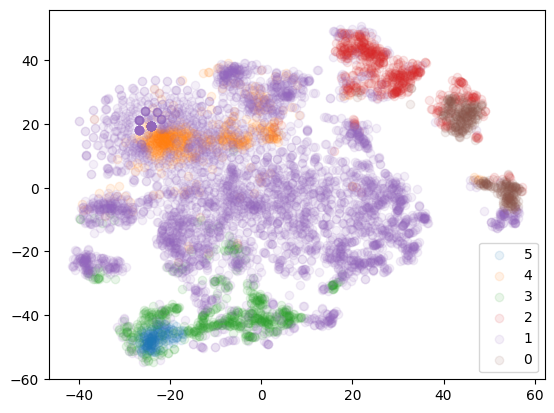

In [176]:
max_n_points = dist_matrix_pca.shape[0]

for label in sorted(np.unique(ac_result))[::-1]:
    dist_matrix_pca_label = dist_matrix_tsne[label==ac_result]
    plt.scatter(dist_matrix_pca_label[:min(dist_matrix_pca_label.shape[0], max_n_points), 0], 
                dist_matrix_pca_label[:min(dist_matrix_pca_label.shape[0], max_n_points), 1], 
                alpha=.1, 
                label=label)

plt.legend()

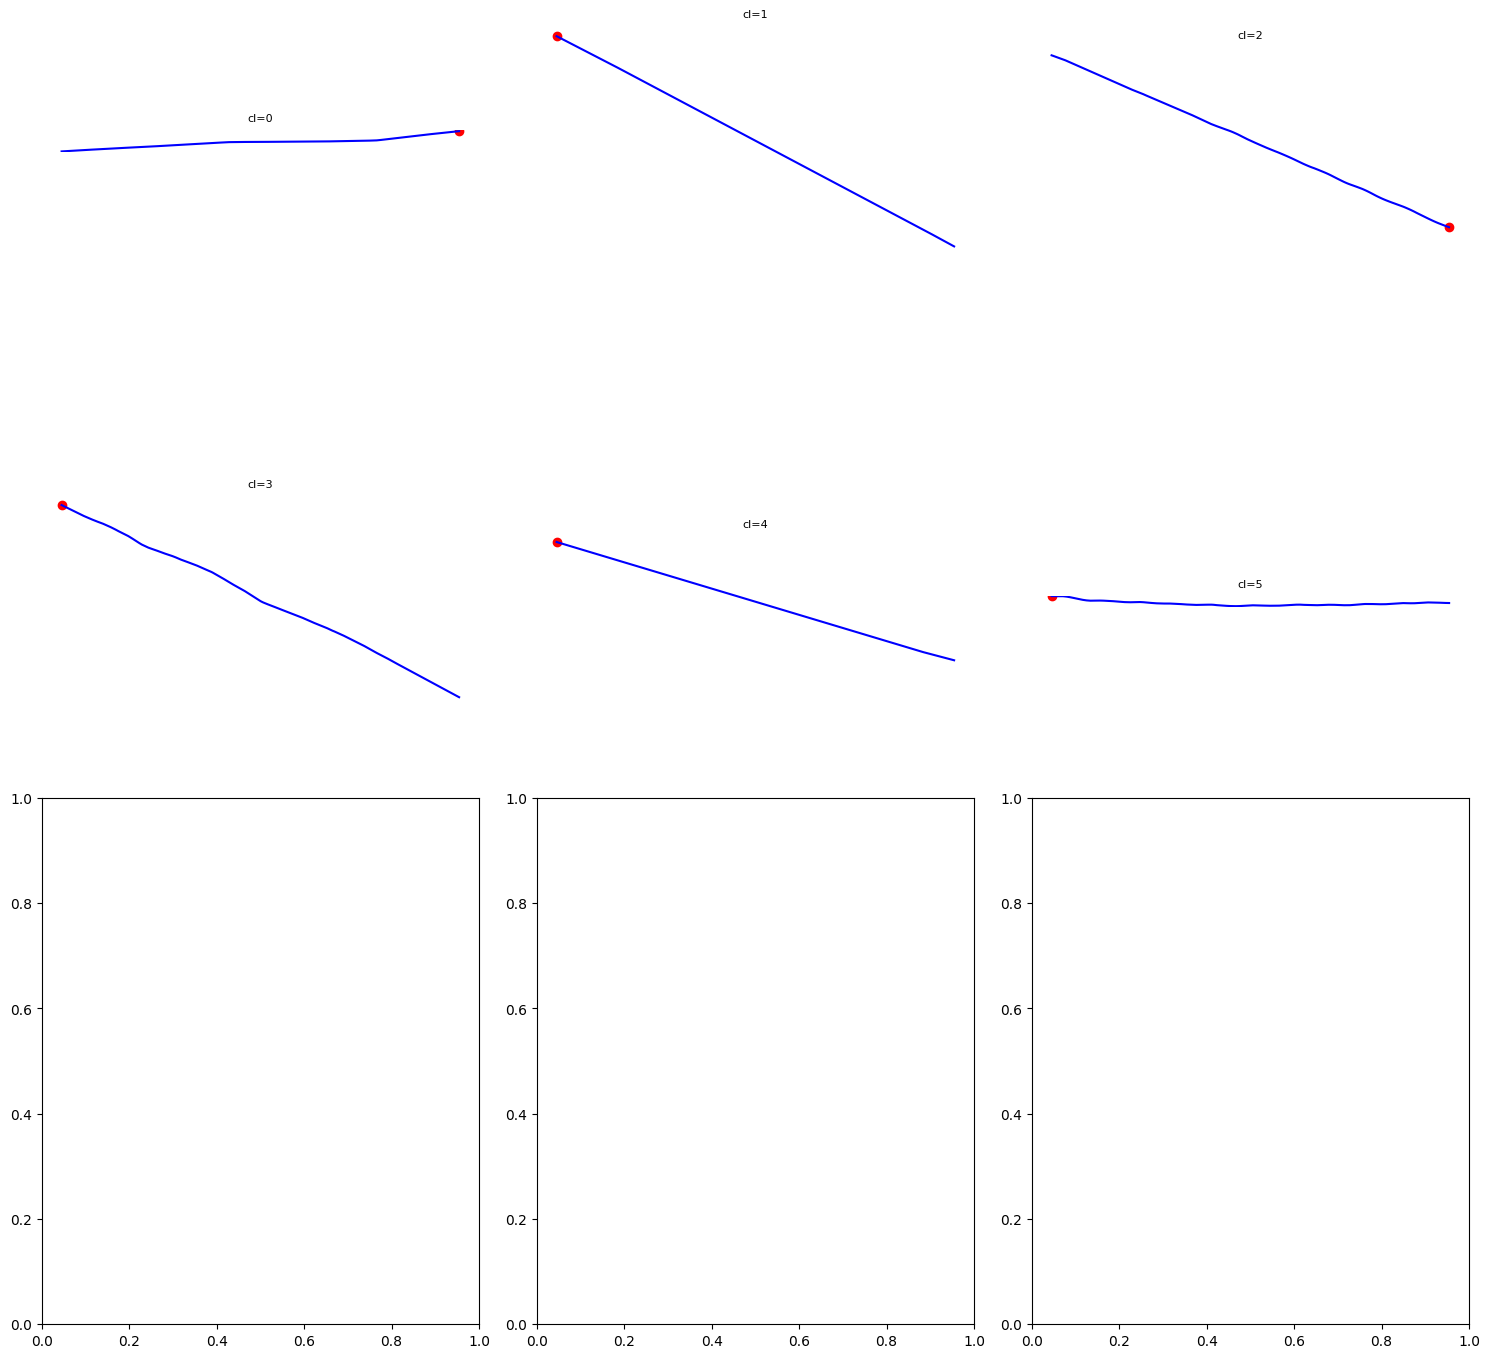

In [177]:
import math

fig, axes = plt.subplots(math.ceil(len(medoids)**.5), math.ceil(len(medoids)**.5), figsize=(15, 15))
axes = axes.flatten()

for ax, (geolet_id, geolet_data) in zip(axes, medoids.items()):
    ax.plot(geolet_data.longitude, geolet_data.latitude, color='blue')
    ax.scatter(geolet_data.longitude[0], geolet_data.latitude[0], color='red')
    ax.set_title(geolet_id.split("_")[0], fontsize=8)
    ax.set_aspect('equal')  # stessa scala per x e y
    ax.axis('off')  # opzionale, per rimuovere gli assi

plt.tight_layout()
plt.show()

## MeanShift

In [192]:
from sklearn.cluster import MeanShift

ms = MeanShift()
ms_result = ms.fit_predict(dist_matrix)

In [193]:
len(np.unique(ms_result))

7

In [194]:
medoids = dict()

intra_cluster_distance = np.zeros((len(geolets),))
for idx, label in enumerate(ms_result):
    intra_cluster_distance[idx] = np.sum(dist_matrix[idx][ms_result == label])

for label in tqdm(np.unique(ms_result), desc="Collecting medoids"):
    min_idx = np.argmin(intra_cluster_distance[ms_result == label])
    key = geolets_keys[ms_result == label][min_idx]
    medoids[f"cl={label}_{key}"] = geolets[key]
    scores = intra_cluster_distance[ms_result == label][min_idx]

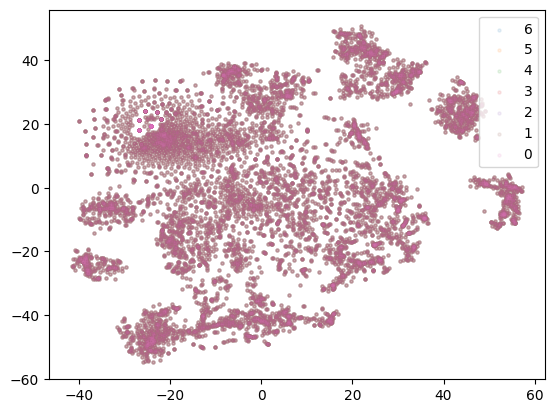

In [195]:
max_n_points = dist_matrix_tsne.shape[0]

for label in sorted(np.unique(ms_result))[::-1]:
    dist_matrix_pca_label = dist_matrix_pca[label==ms_result]
    plt.scatter(dist_matrix_tsne[:min(dist_matrix_tsne.shape[0], max_n_points), 0], 
                dist_matrix_tsne[:min(dist_matrix_tsne.shape[0], max_n_points), 1], 
                alpha=.1, 
                s=5,
                label=label)

plt.legend()

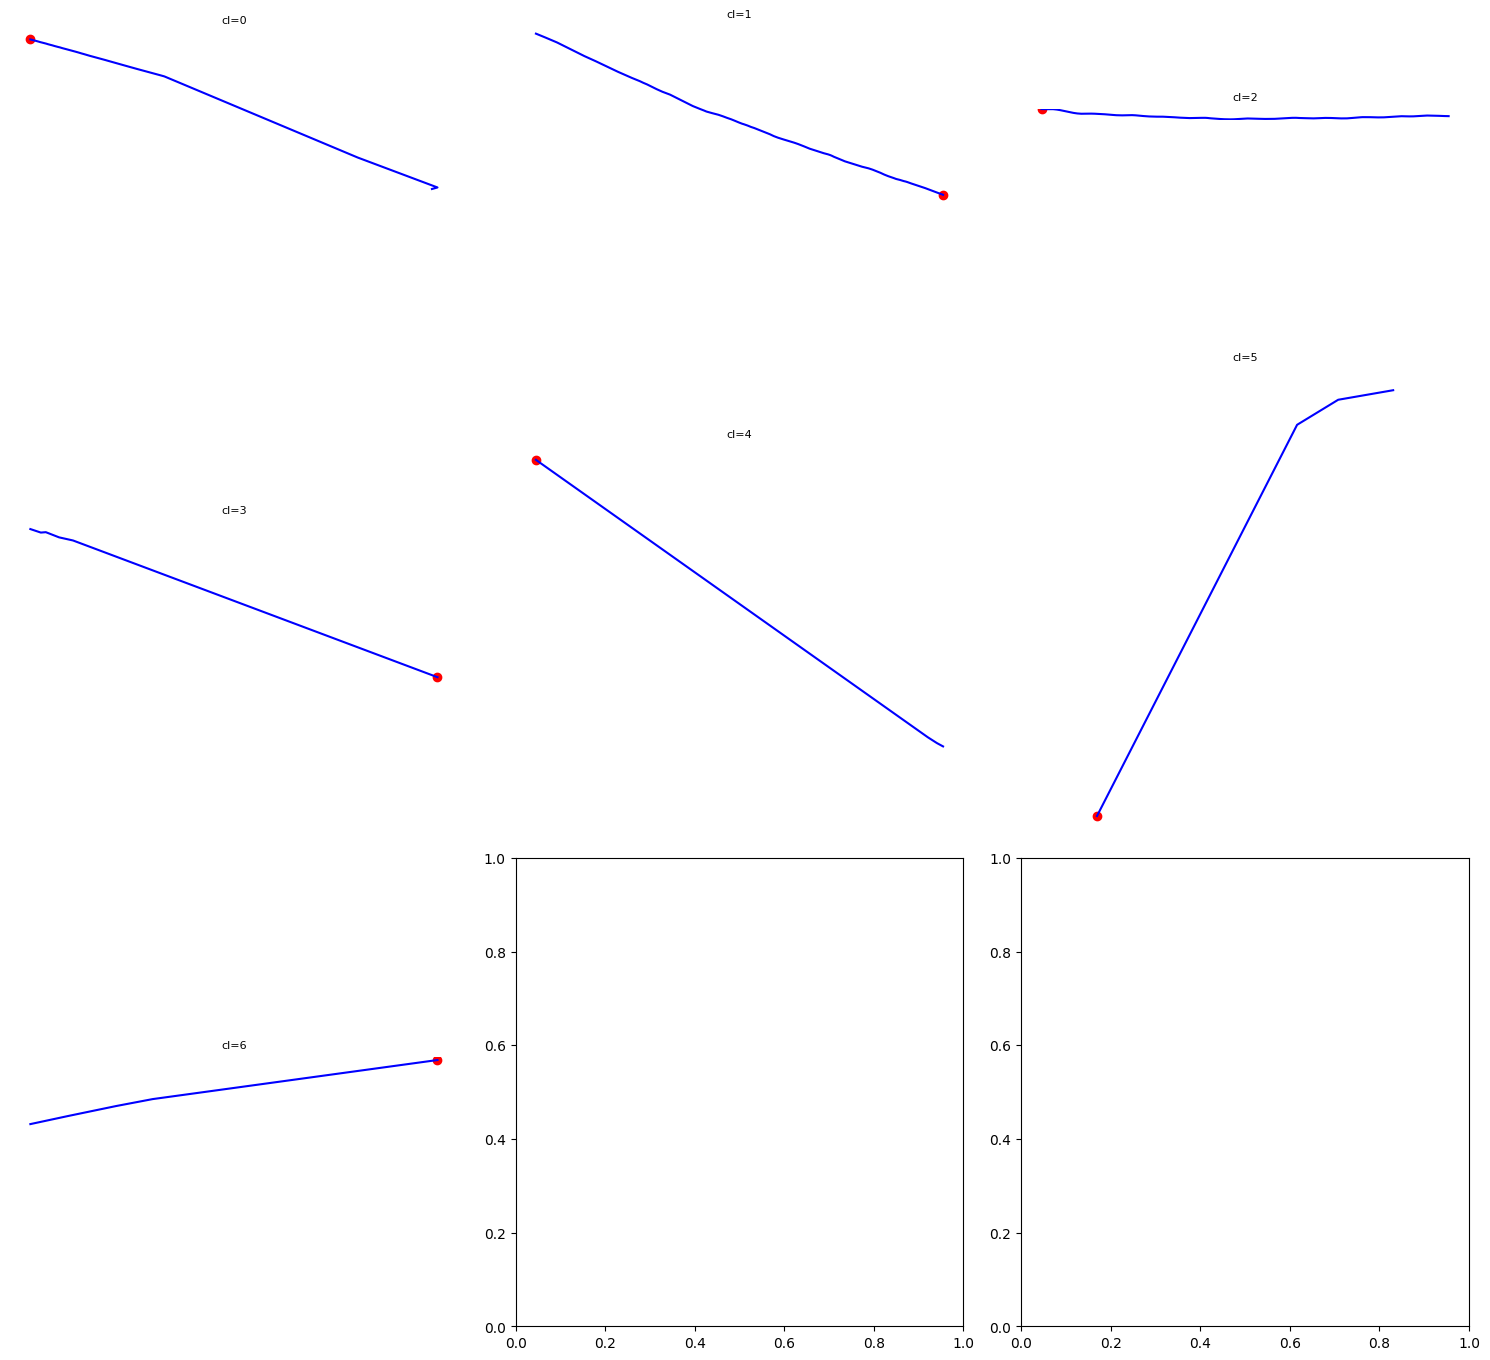

In [196]:
import math

fig, axes = plt.subplots(math.ceil(len(medoids)**.5), math.ceil(len(medoids)**.5), figsize=(15, 15))
axes = axes.flatten()

for ax, (geolet_id, geolet_data) in zip(axes, medoids.items()):
    ax.plot(geolet_data.longitude, geolet_data.latitude, color='blue')
    ax.scatter(geolet_data.longitude[0], geolet_data.latitude[0], color='red')
    ax.set_title(geolet_id.split("_")[0], fontsize=8)
    ax.set_aspect('equal')  # stessa scala per x e y
    ax.axis('off')  # opzionale, per rimuovere gli assi

plt.tight_layout()
plt.show()

## Self-organizing maps

In [197]:
from minisom import MiniSom

In [206]:
som_shape = (100, 1)
som = MiniSom(som_shape[0], som_shape[1], dist_matrix.shape[1], sigma=.8, learning_rate=.5,
              neighborhood_function='gaussian', random_seed=42)

som.train_batch(dist_matrix, 10000, verbose=True)

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 1.4693562326996799


In [207]:
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in tqdm(dist_matrix)]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

  0%|          | 0/6159 [00:00<?, ?it/s]

In [208]:
centroids_position = []

def find_nearest(centroid, dist_matrix):
    delta_dist_matrix = np.abs(dist_matrix - centroid.flatten())
    return np.argmin(delta_dist_matrix.sum(axis=1))

for centroid in tqdm(som.get_weights()):
    centroids_position += [find_nearest(centroid, dist_matrix)]

centroids_position = list(set(centroids_position))
sorted(centroids_position)

  0%|          | 0/100 [00:00<?, ?it/s]

[378,
 1055,
 1597,
 2169,
 3200,
 3311,
 3516,
 3542,
 3642,
 3915,
 5097,
 5124,
 5470,
 5729]

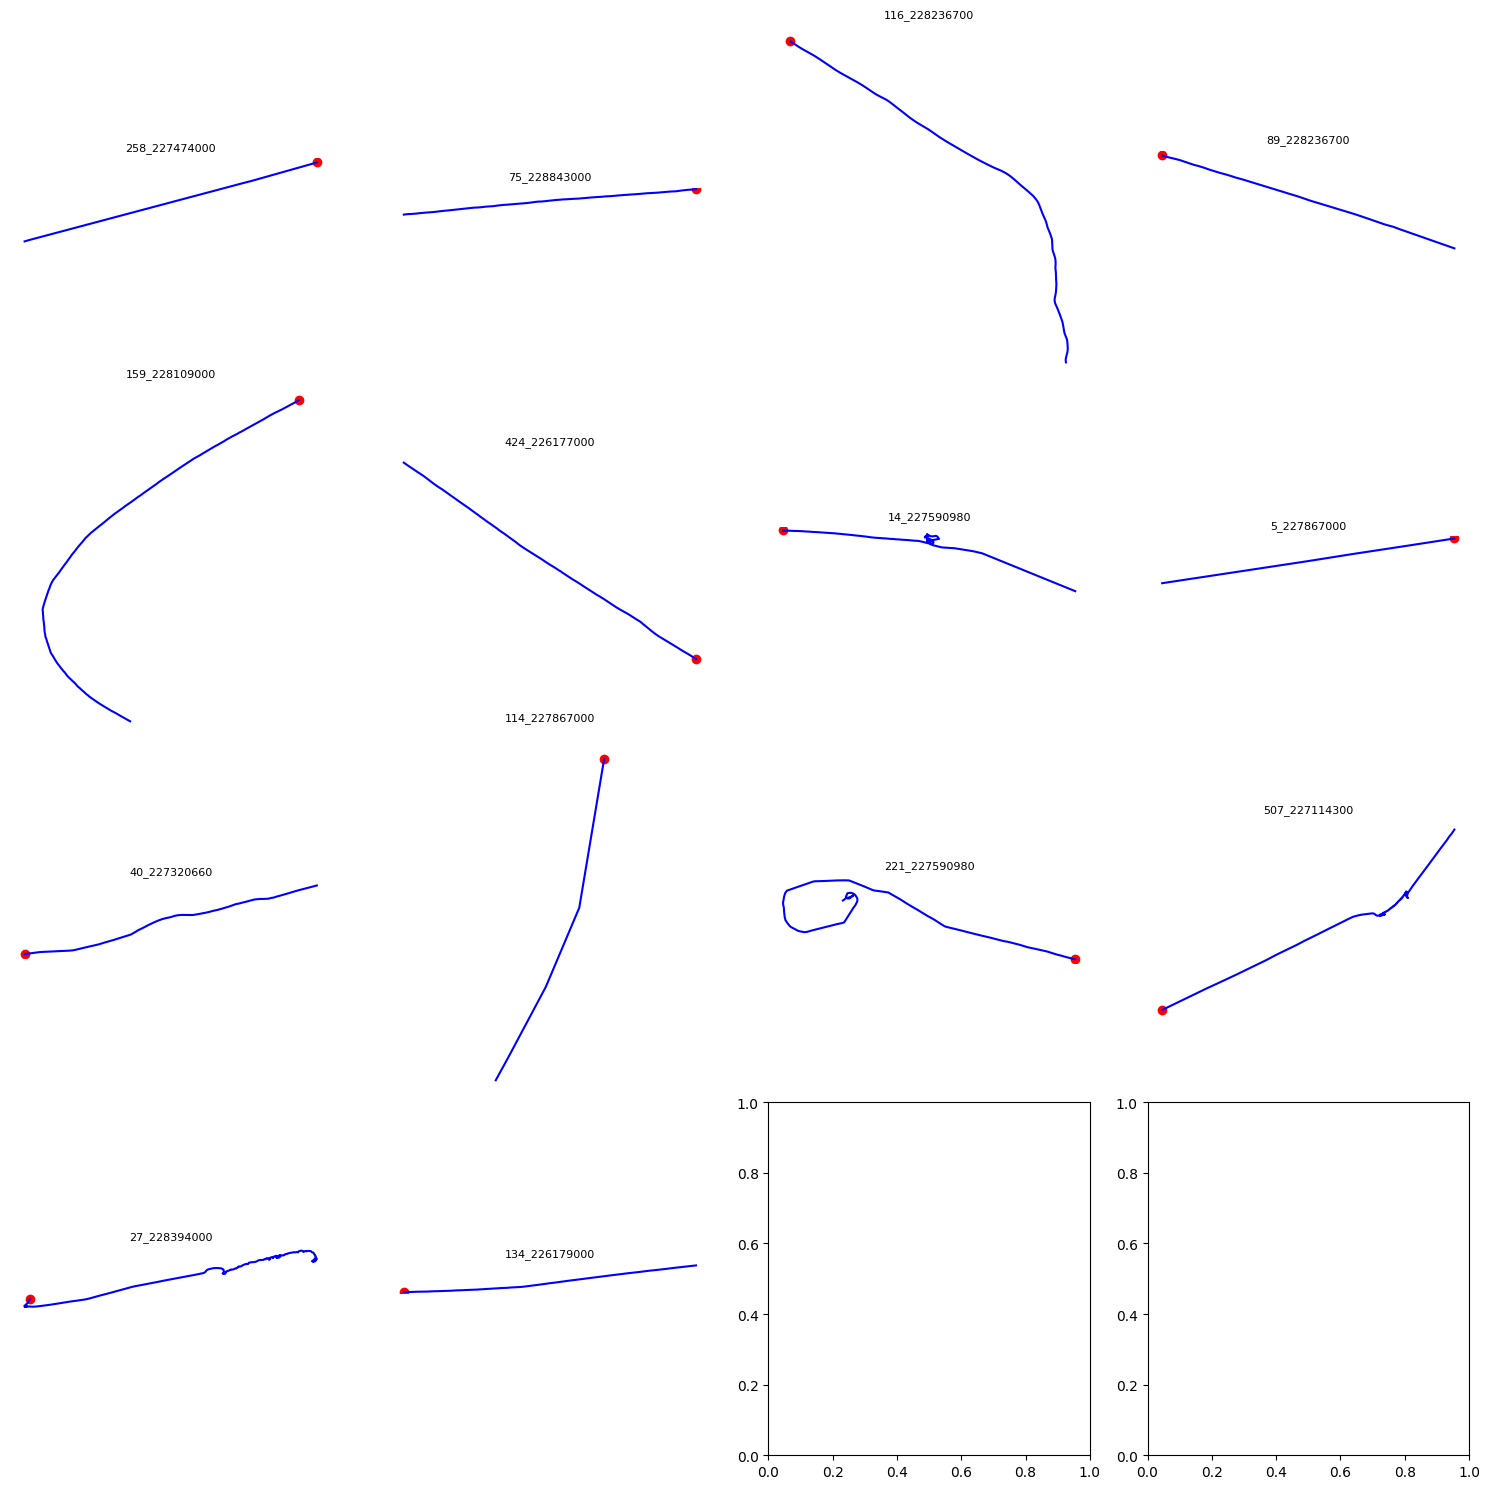

In [209]:
import math

fig, axes = plt.subplots(math.ceil(len(centroids_position)**.5), math.ceil(len(centroids_position)**.5), figsize=(15, 15))
axes = axes.flatten()

for ax, geolet_id in zip(axes, geolets_keys[centroids_position]):
    geolet_data = geolets[geolet_id]
    ax.plot(geolet_data.longitude, geolet_data.latitude, color='blue')
    ax.scatter(geolet_data.longitude[0], geolet_data.latitude[0], color='red')
    ax.set_title(geolet_id, fontsize=8)
    ax.set_aspect('equal')  # stessa scala per x e y
    ax.axis('off')  # opzionale, per rimuovere gli assi

plt.tight_layout()
plt.show()

## SpectralClustering

In [218]:
from sklearn.cluster import SpectralClustering

sc = SpectralClustering(n_clusters=25, n_jobs=32,affinity='precomputed_nearest_neighbors', verbose=False)
sc_results = sc.fit_predict(dist_matrix)
len(np.unique(sc_results))

25

In [226]:
medoids = dict()

intra_cluster_distance = np.zeros((len(geolets),))
for idx, label in enumerate(sc_results):
    intra_cluster_distance[idx] = np.sum(dist_matrix[idx][sc_results == label])

for label in tqdm(np.unique(sc_results), desc="Collecting medoids"):
    min_idx = np.argmin(intra_cluster_distance[sc_results == label])
    key = geolets_keys[sc_results == label][min_idx]
    medoids[f"cl={label}_{key}"] = geolets[key]
    scores = intra_cluster_distance[sc_results == label][min_idx]

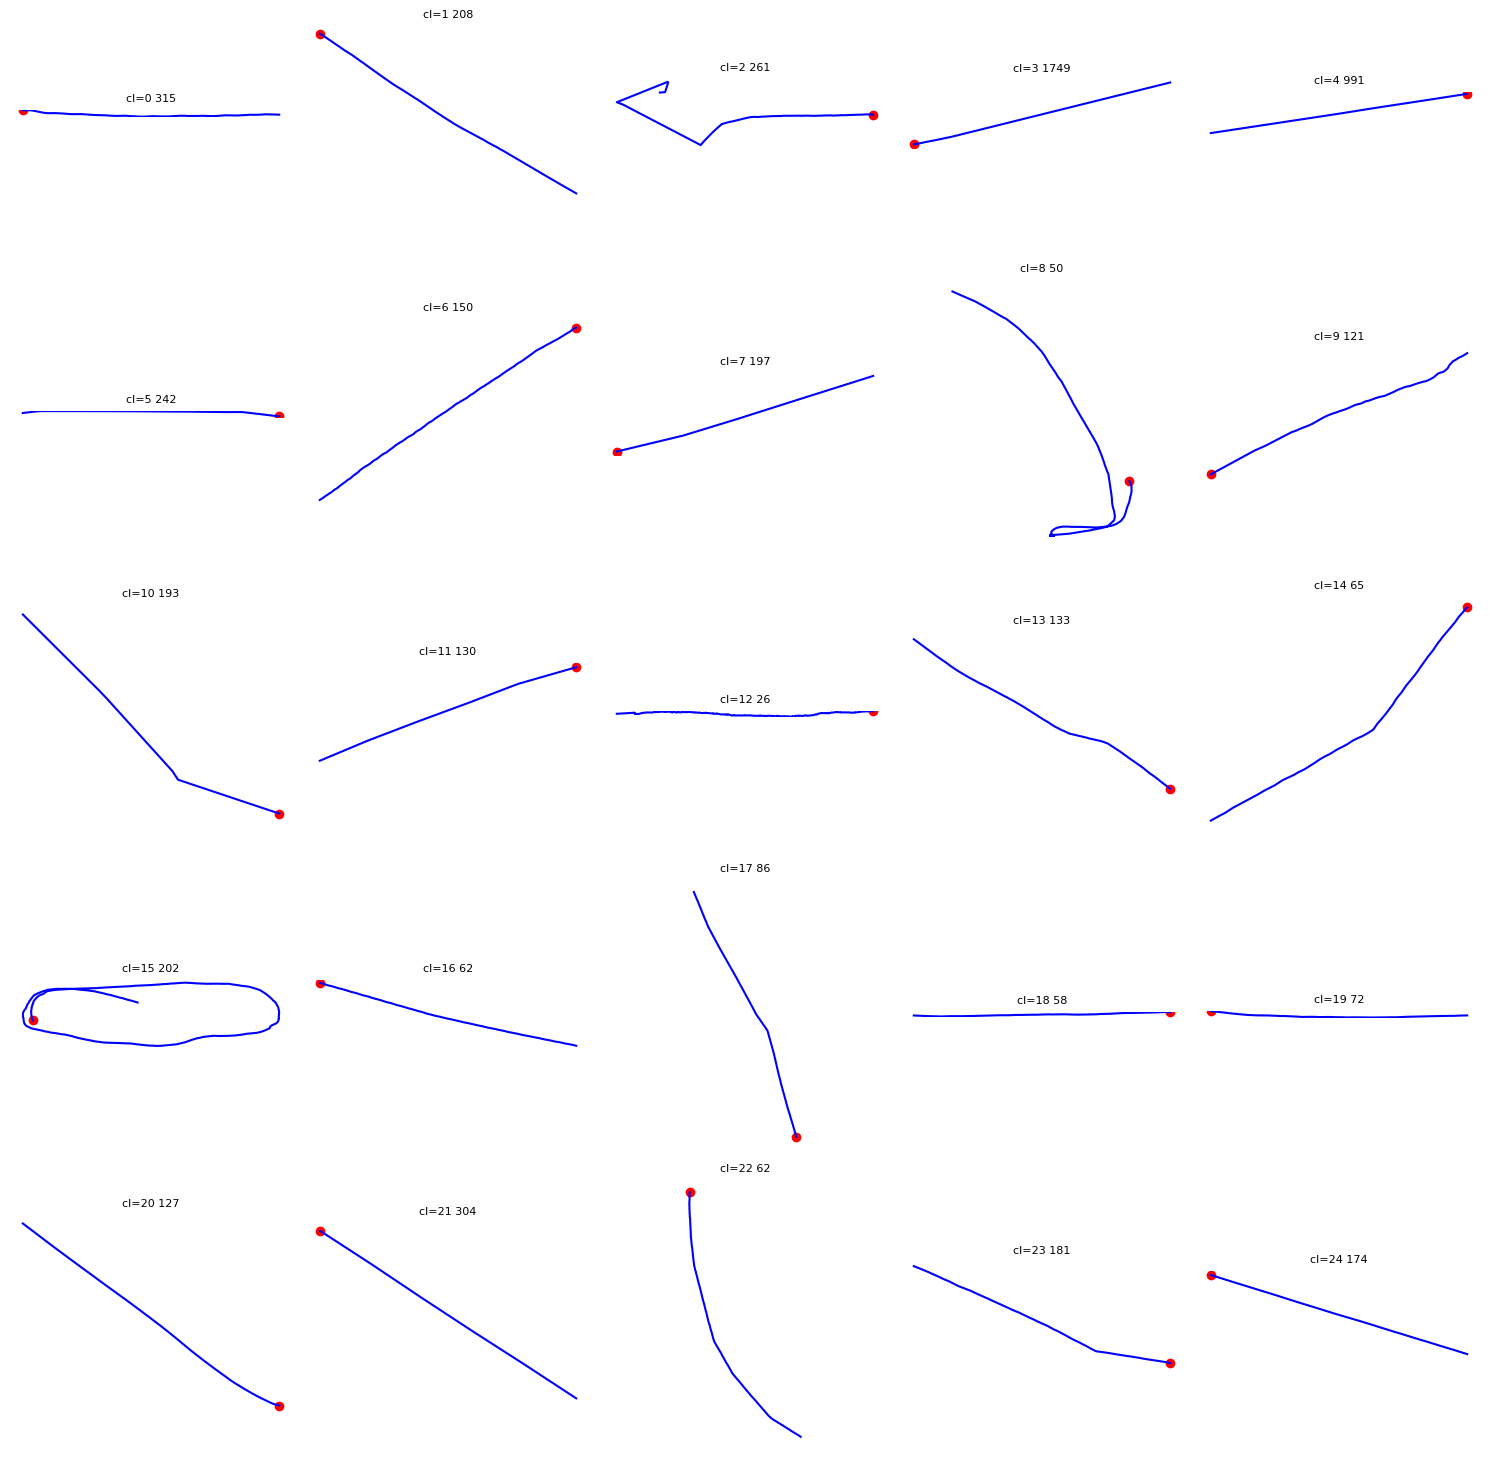

In [229]:
fig, axes = plt.subplots(math.ceil(len(medoids)**.5), math.ceil(len(medoids)**.5), figsize=(15, 15))
axes = axes.flatten()

for ax, (geolet_id, geolet_data) in zip(axes, medoids.items()):
    ax.plot(geolet_data.longitude, geolet_data.latitude, color='blue')
    ax.scatter(geolet_data.longitude[0], geolet_data.latitude[0], color='red')
    ax.set_title(geolet_id.split("_")[0]+f' {len(np.where(sc_results == int(geolet_id.split("_")[0][3:]))[0])}', fontsize=8)
    ax.set_aspect('equal')  # stessa scala per x e y
    ax.axis('off')  # opzionale, per rimuovere gli assi

plt.tight_layout()
plt.show()

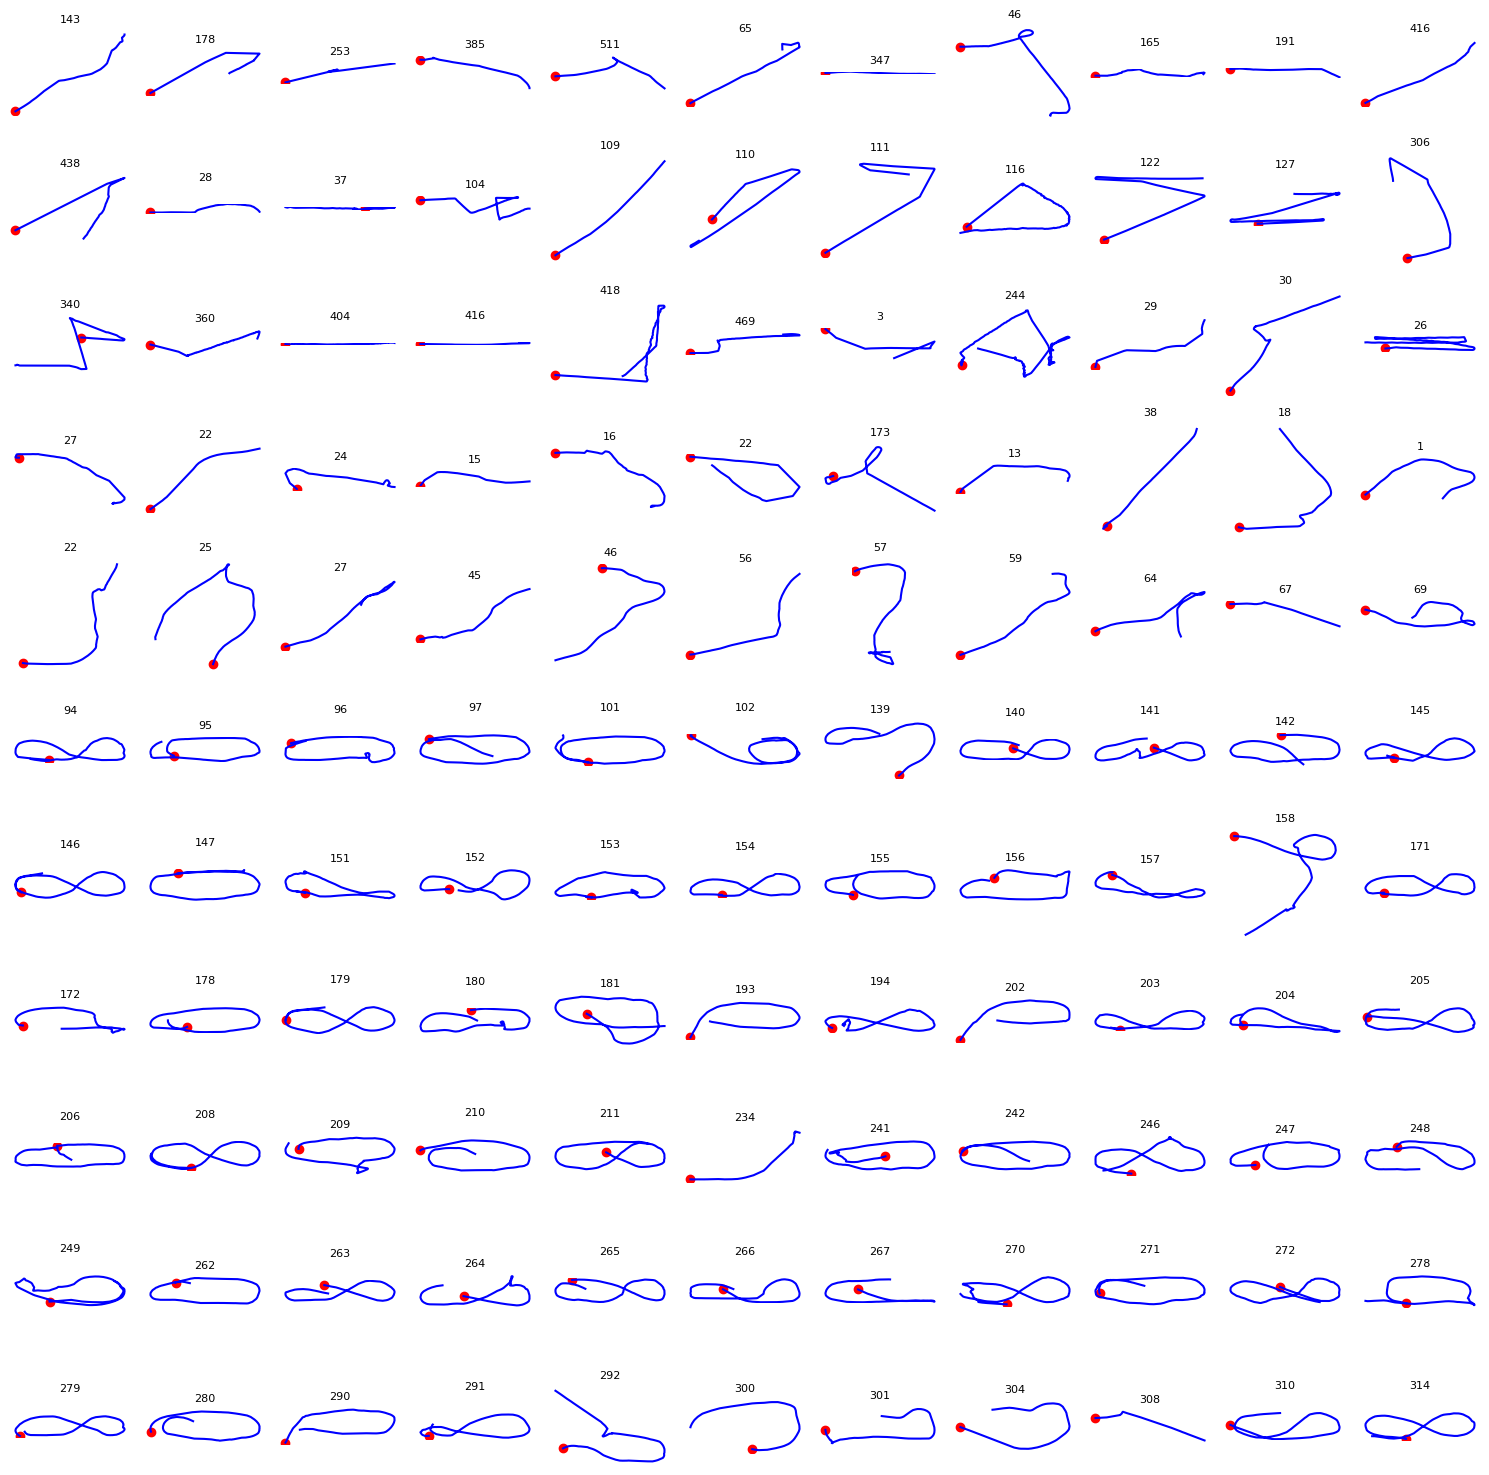

In [238]:
medoids = geolets_keys[sc_results==15][:11**2]

fig, axes = plt.subplots(math.ceil(len(medoids)**.5), math.ceil(len(medoids)**.5), figsize=(15, 15))
axes = axes.flatten()

for ax, (geolet_id) in zip(axes, medoids):
    geolet_data = geolets[geolet_id]
    ax.plot(geolet_data.longitude, geolet_data.latitude, color='blue')
    ax.scatter(geolet_data.longitude[0], geolet_data.latitude[0], color='red')
    ax.set_title(geolet_id.split("_")[0], fontsize=8)
    ax.set_aspect('equal')  # stessa scala per x e y
    ax.axis('off')  # opzionale, per rimuovere gli assi

plt.tight_layout()
plt.show()